In [78]:
import numpy as np
import h5py
filename = "GW2_Andy.h5"
hdf = h5py.File(filename, 'r')
print(list(hdf.keys()))
background=hdf['background']
bbh=hdf['binaryblackhole']
ccsn=hdf['ccsn']
glitch=hdf['glitch']

['background', 'binaryblackhole', 'ccsn', 'glitch']


In [79]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from typing import Iterable, List
from timeit import default_timer as timer
import scipy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Transformer
from torch import Tensor


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [80]:
### Define model

## Add batch normalization and dropout to the model


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.batch_norm3 = nn.BatchNorm2d(64)

        self.dropout = nn.Dropout(p=0.4)

        self.fc1 = nn.Linear(64*11*9, 64)
        self.fc2 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))

        x = x.view(-1, 64*11*9)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [81]:
### Load the pytorch model "Scratch-work/Project/5_26_710_model.pt"
model = Net()
model.load_state_dict(torch.load("5_26_710_model.pt"))
model.eval()


Net(
  (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=6336, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

In [82]:
### Reshape data to (2, 2048, 4096)

bbh = np.array([bbh[:,0], bbh[:,1]])
background = np.array([background[:,0], background[:,1]])
ccsn = np.array([ccsn[:,0], ccsn[:,1]])
glitch = np.array([glitch[:,0], glitch[:,1]])


# print shape
bbh.shape


(2, 2048, 4096)

In [83]:
### Spectrogram function

# create a function that takes in an array of shape (2, 4096) and outputs a spectrogram of shape (2, 128 x 128) using scipy.signal.spectrogram

dt = 0.001

def make_spectrogram (array):
    spec_in = scipy.signal.spectrogram(array, fs=1/dt, nperseg=175, noverlap=120, mode = 'magnitude')
    spec = spec_in[2]
    return spec



In [84]:
### Use function to create spectrograms for all data
### the input data has shape (2, 2048, 4096), and the output data should have shape (2, 2048, x, y) 
### where x and y are the spectrogram dimensions

def convert_data_to_spectrogram (data):
    spectrogram = np.zeros((2, 2048, 88, 72))
    for i in range(2048):
        spectrogram[:,i,:,:] = make_spectrogram(data[:,i,:])
    return spectrogram



In [85]:
### Create spectrograms for all data

bbh_spectrogram = convert_data_to_spectrogram(bbh)
background_spectrogram = convert_data_to_spectrogram(background)
ccsn_spectrogram = convert_data_to_spectrogram(ccsn)
glitch_spectrogram = convert_data_to_spectrogram(glitch)


### Normalize spectrograms

scaler = StandardScaler()

background_spectrogram_norm = scaler.fit_transform(background_spectrogram.reshape(2*2048, 88*72))
bbh_spectrogram_norm = scaler.fit_transform(bbh_spectrogram.reshape(2*2048, 88*72))
ccsn_spectrogram_norm = scaler.fit_transform(ccsn_spectrogram.reshape(2*2048, 88*72))
glitch_spectrogram_norm = scaler.fit_transform(glitch_spectrogram.reshape(2*2048, 88*72))


### Reshape spectrograms

bbh_spectrogram_norm = bbh_spectrogram_norm.reshape(2, 2048, 88, 72)
background_spectrogram_norm = background_spectrogram_norm.reshape(2, 2048, 88, 72)
ccsn_spectrogram_norm = ccsn_spectrogram_norm.reshape(2, 2048, 88, 72)
glitch_spectrogram_norm = glitch_spectrogram_norm.reshape(2, 2048, 88, 72)


### convert above arrays to tensors of the following shape
### (2, 2048, 88, 72) -> (2048, 2, 88, 72) -- (samples, channels, x, y )

bbh_tensor = torch.from_numpy(bbh_spectrogram_norm).permute(1,0,2,3)
background_tensor = torch.from_numpy(background_spectrogram_norm).permute(1,0,2,3)
ccsn_tensor = torch.from_numpy(ccsn_spectrogram_norm).permute(1,0,2,3)
glitch_tensor = torch.from_numpy(glitch_spectrogram_norm).permute(1,0,2,3)


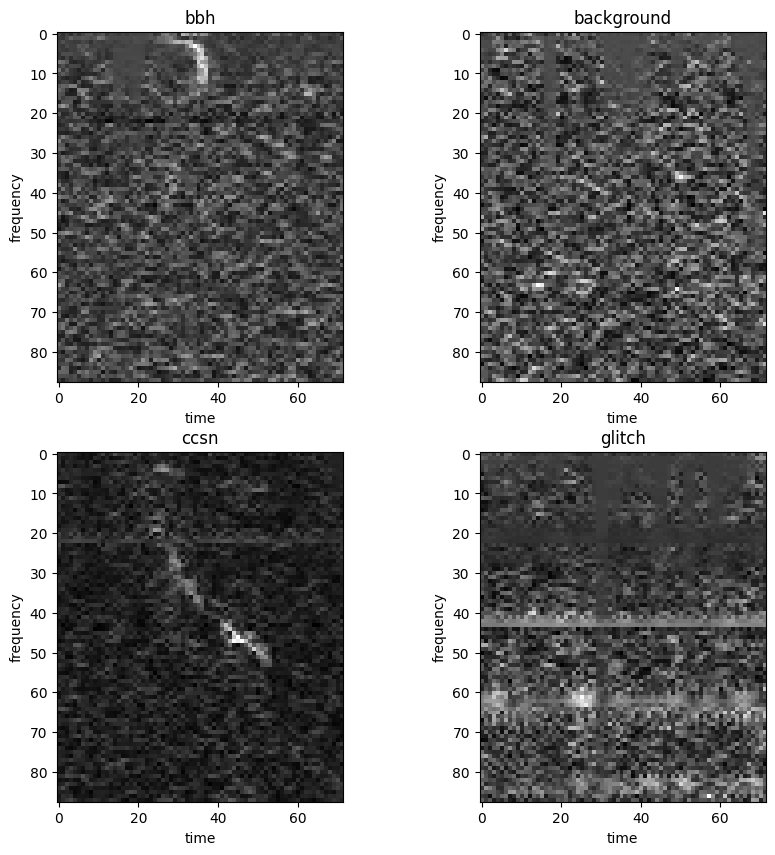

In [86]:
# Show plots of spectrograms for each class in a 2x2 grid using imshow
# use the second index of the tensors as the Red and Blue channels of the image

fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].imshow(bbh_tensor[25,0,:,:], cmap='gray')
axs[0, 0].set_title('bbh')
axs[0, 1].imshow(background_tensor[0,0,:,:], cmap='gray')
axs[0, 1].set_title('background')
axs[1, 0].imshow(ccsn_tensor[0,0,:,:], cmap='gray')
axs[1, 0].set_title('ccsn')
axs[1, 1].imshow(glitch_tensor[50,0,:,:], cmap='gray')
axs[1, 1].set_title('glitch')

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='frequency')





In [87]:
### Label the data and put into a data loader. We are only testing the model here, so we will use the entire dataset

# Convert to tensors
bbh_tensor = torch.from_numpy(bbh_spectrogram_norm).permute(1,0,2,3)
background_tensor = torch.from_numpy(background_spectrogram_norm).permute(1,0,2,3)
ccsn_tensor = torch.from_numpy(ccsn_spectrogram_norm).permute(1,0,2,3)
glitch_tensor = torch.from_numpy(glitch_spectrogram_norm).permute(1,0,2,3)

# Add labels
bbh_label = torch.zeros(2048, dtype=torch.long)
background_label = torch.ones(2048, dtype=torch.long)
ccsn_label = torch.ones(2048, dtype=torch.long) + 1
glitch_label = torch.ones(2048, dtype=torch.long) + 2


# Create datasets with labels
bbh_dataset = torch.utils.data.TensorDataset(bbh_tensor, bbh_label)
background_dataset = torch.utils.data.TensorDataset(background_tensor, background_label)
ccsn_dataset = torch.utils.data.TensorDataset(ccsn_tensor, ccsn_label)
glitch_dataset = torch.utils.data.TensorDataset(glitch_tensor, glitch_label)

dataset = torch.utils.data.ConcatDataset([bbh_dataset, background_dataset, ccsn_dataset, glitch_dataset])

# Create dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [101]:
## Function to check accuracy of model

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for images, labels in loader:
            scores = model(images.float())
            _, predictions = scores.max(1)
            num_correct += (predictions == labels).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()

In [102]:
check_accuracy(dataloader, model)

Got 8191 / 8192 with accuracy 99.99


In [114]:
label_dict = {0:'bbh', 1:'background', 2:'ccsn', 3:'glitch'}

Showing incorrect predictions

Predicted glitch but was background


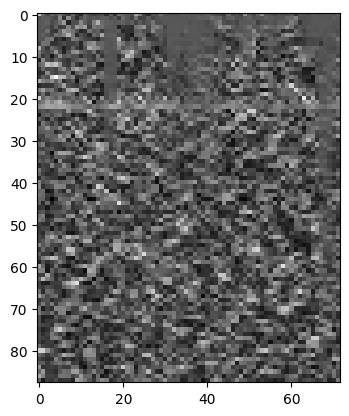

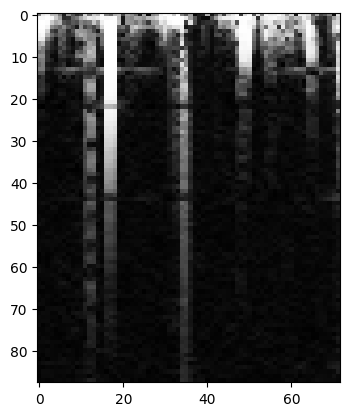

In [117]:
## show incorrect predictions

def show_incorrect(loader, model):

    model.eval()
    print('Showing incorrect predictions\n')
    
    with torch.no_grad():
        for images, labels in loader:
            scores = model(images.float())
            _, predictions = scores.max(1)
            incorrect = (predictions != labels).nonzero()
            for i in incorrect:
                pred = (predictions.numpy())[i]
                label = (labels.numpy())[i]
                print(f'Predicted {label_dict[pred]} but was {label_dict[label]}')
                plt.imshow(images[i,0,:,:][0], cmap='gray')
                plt.show()
                plt.imshow(images[i,1,:,:][0], cmap='gray')
                plt.show()
        

show_incorrect(dataloader, model)

Showing correct predictions

Predicted bbh and was bbh


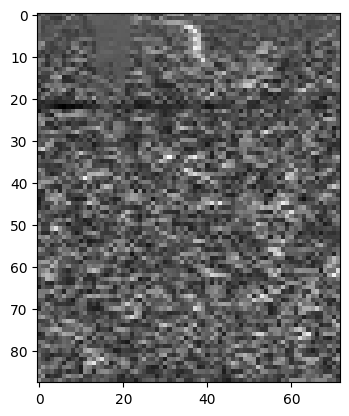

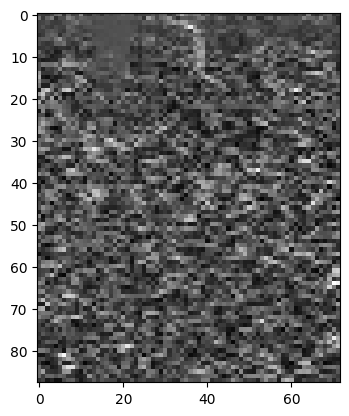

Predicted bbh and was bbh


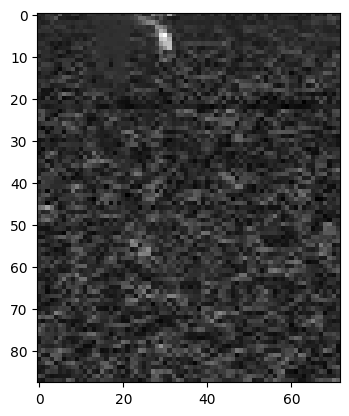

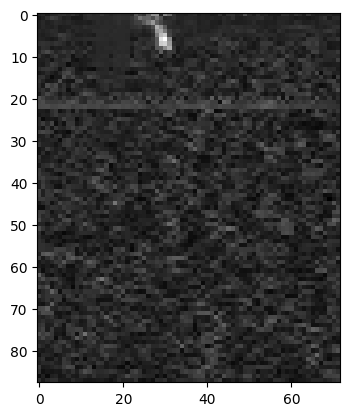

Predicted background and was background


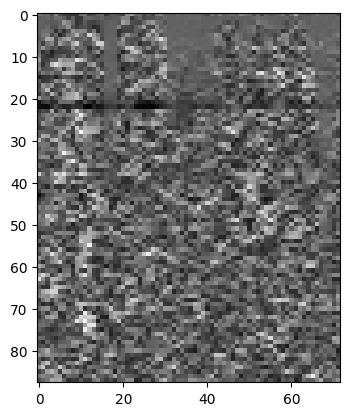

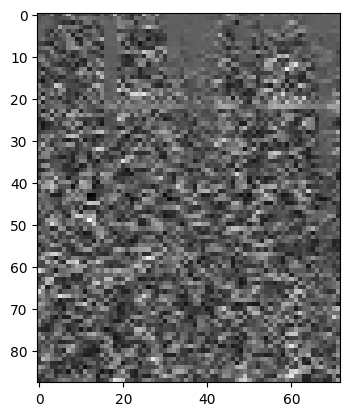

Predicted ccsn and was ccsn


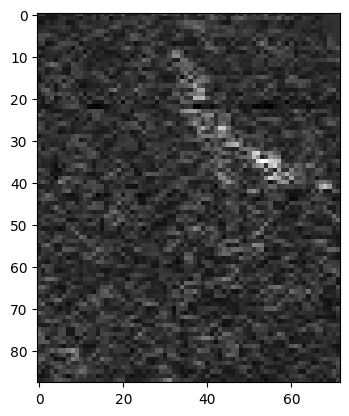

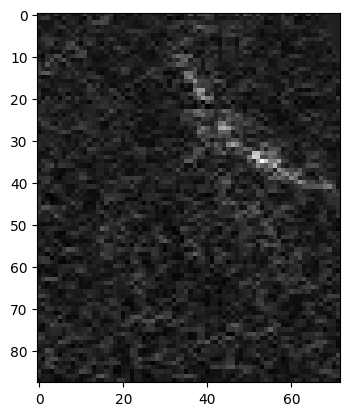

Predicted glitch and was glitch


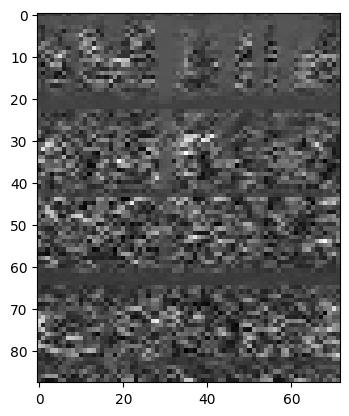

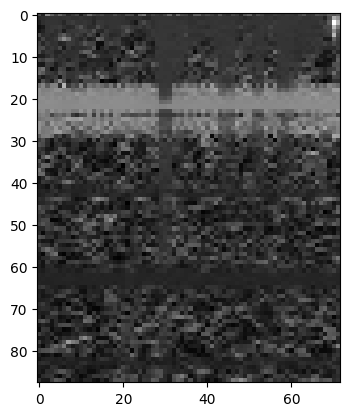

Predicted bbh and was bbh


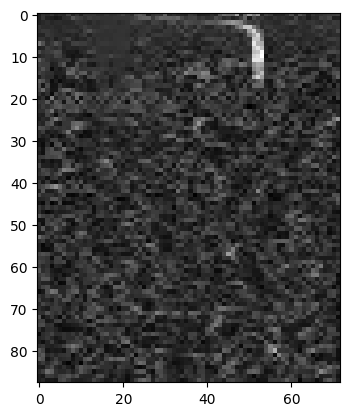

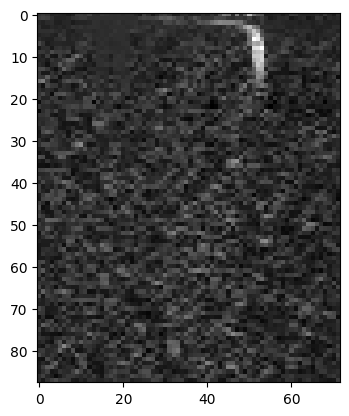

Predicted background and was background


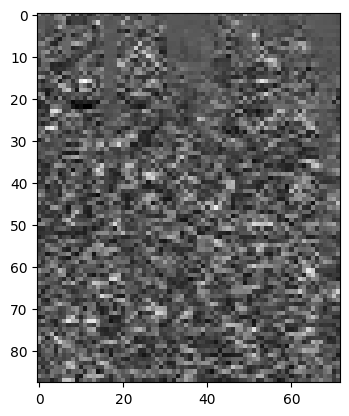

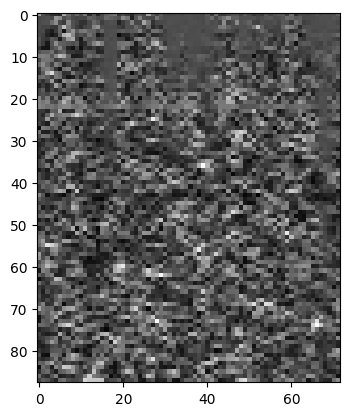

Predicted background and was background


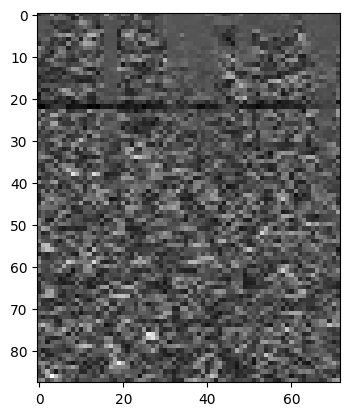

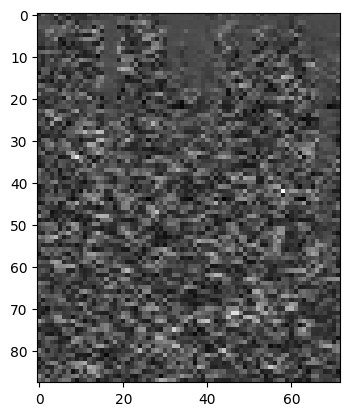

Predicted bbh and was bbh


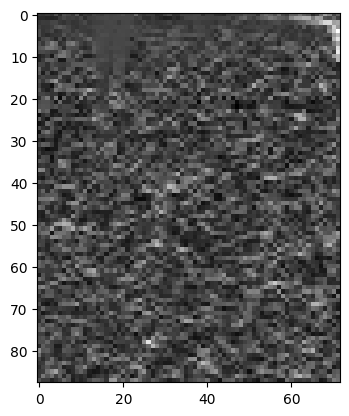

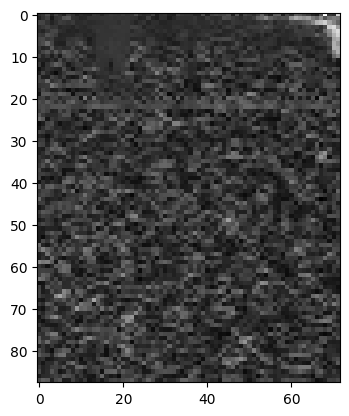

Predicted ccsn and was ccsn


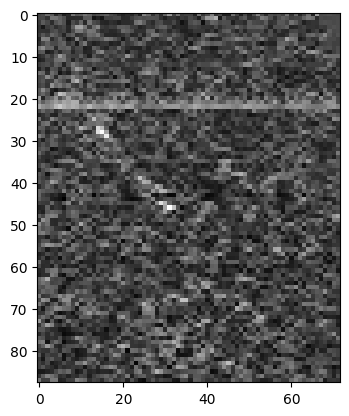

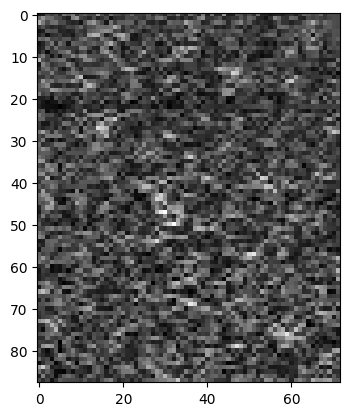

Predicted bbh and was bbh


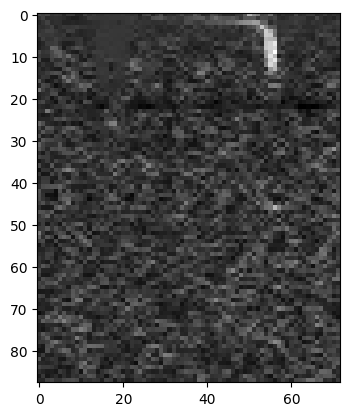

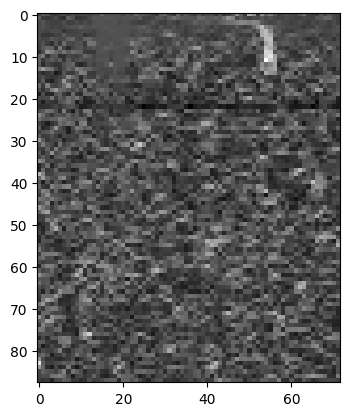

Predicted bbh and was bbh


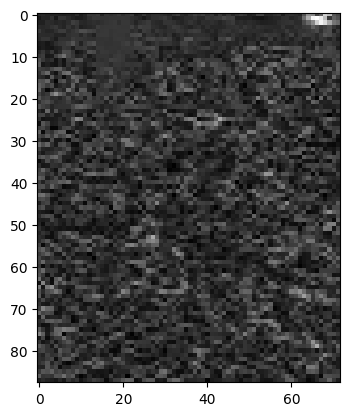

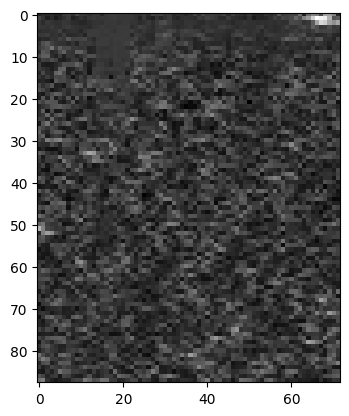

Predicted bbh and was bbh


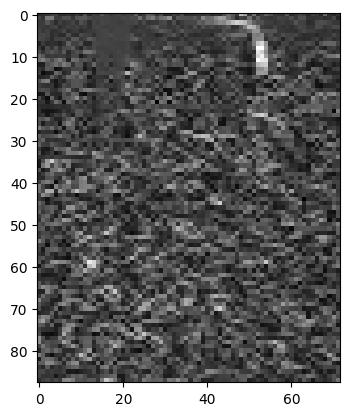

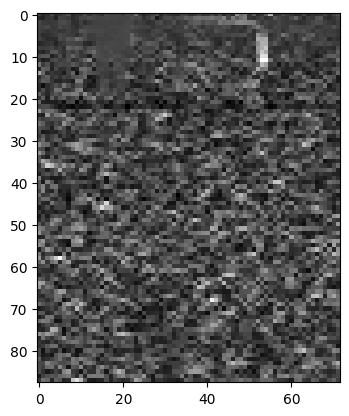

Predicted ccsn and was ccsn


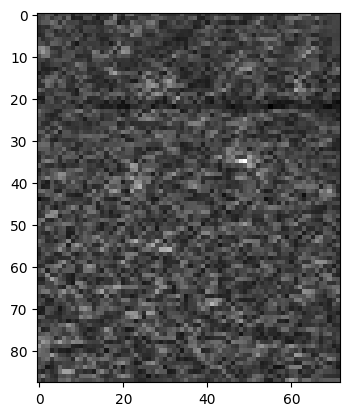

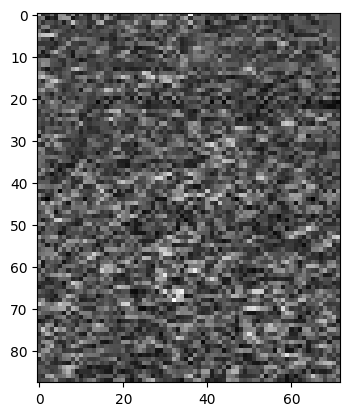

Predicted ccsn and was ccsn


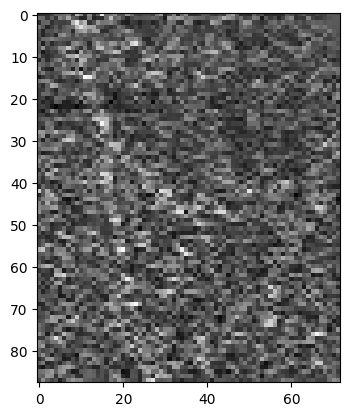

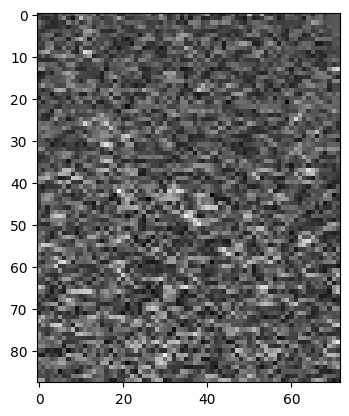

Predicted glitch and was glitch


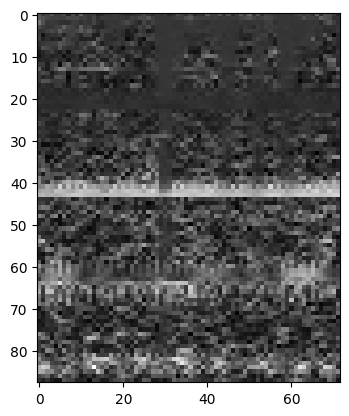

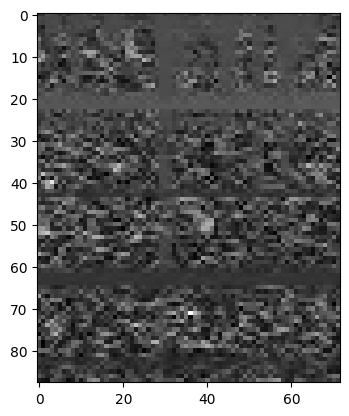

Predicted ccsn and was ccsn


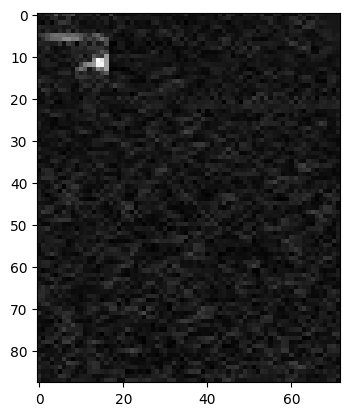

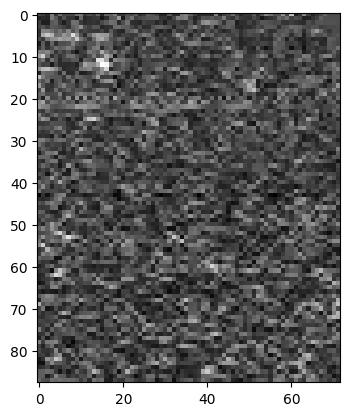

Predicted background and was background


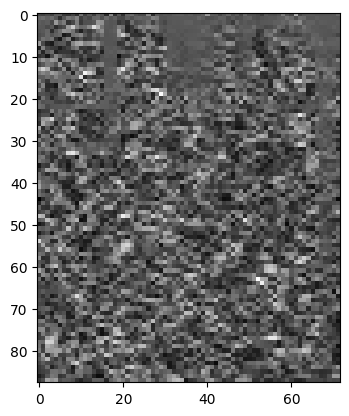

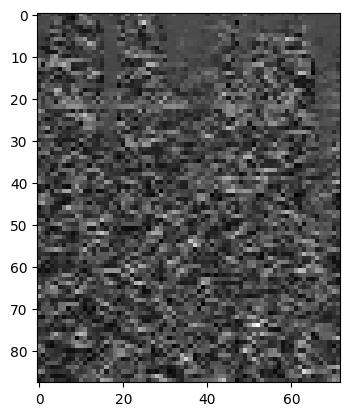

Predicted background and was background


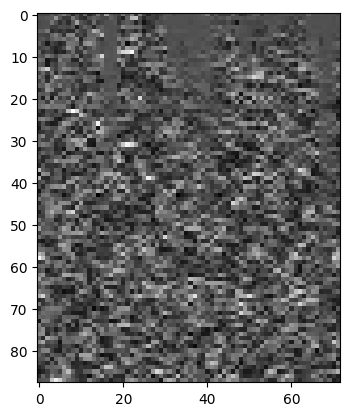

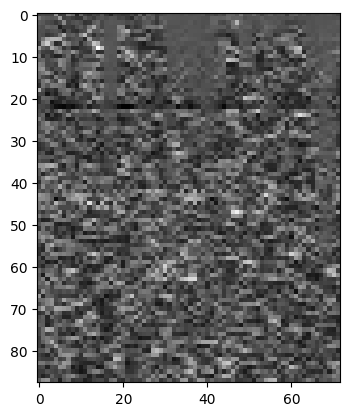

Predicted background and was background


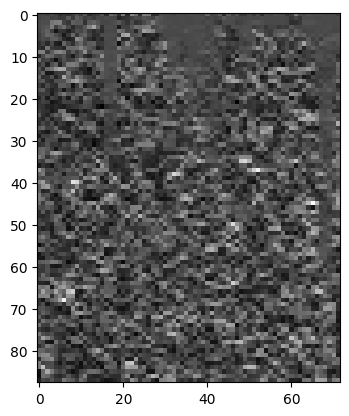

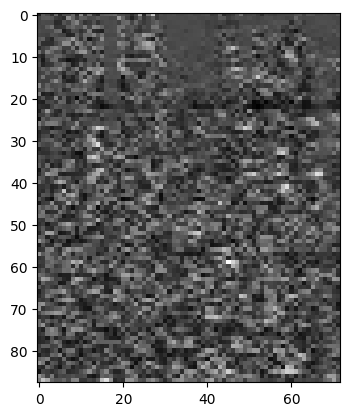

Predicted background and was background


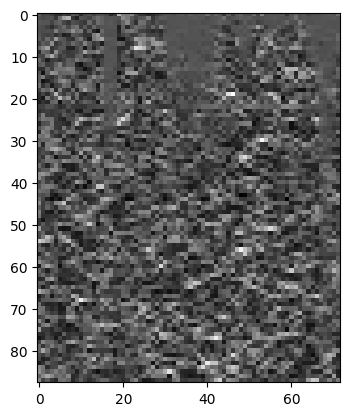

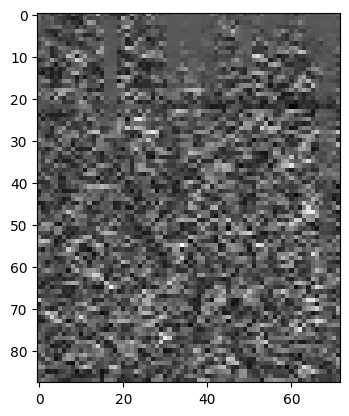

Predicted background and was background


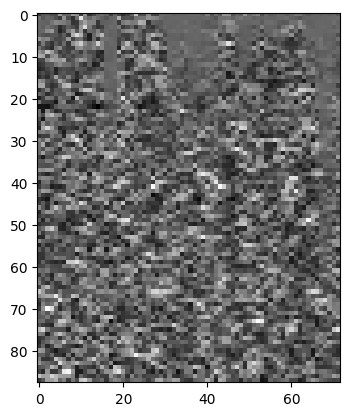

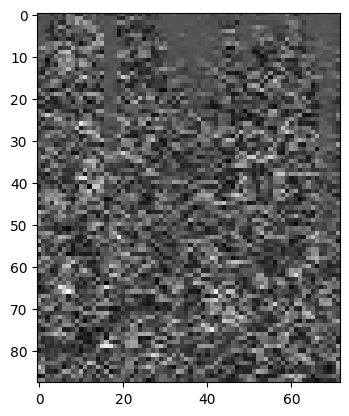

Predicted glitch and was glitch


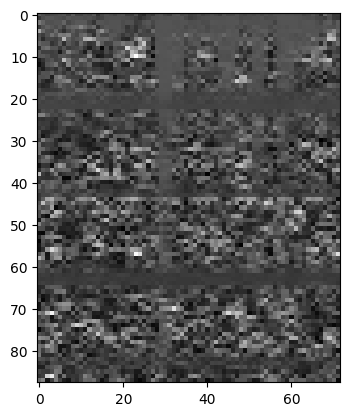

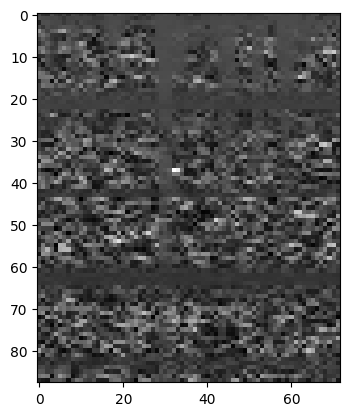

Predicted bbh and was bbh


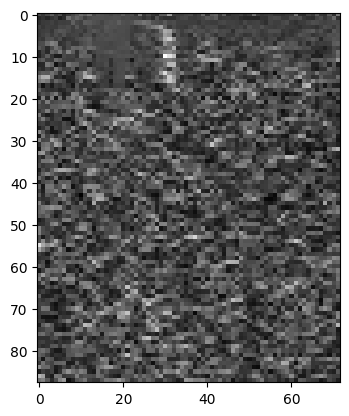

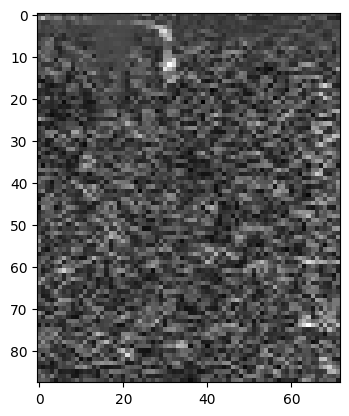

Predicted bbh and was bbh


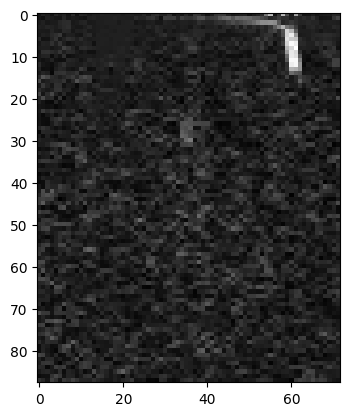

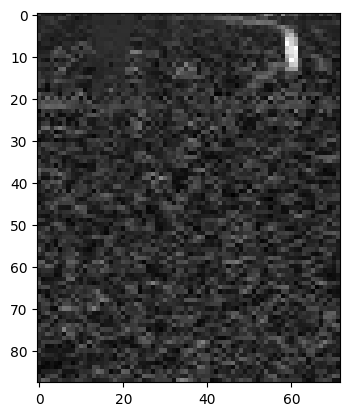

Predicted glitch and was glitch


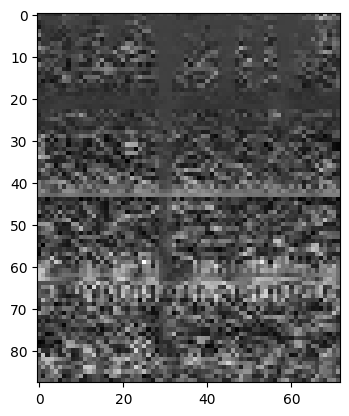

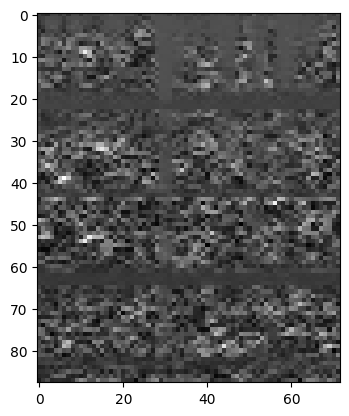

Predicted background and was background


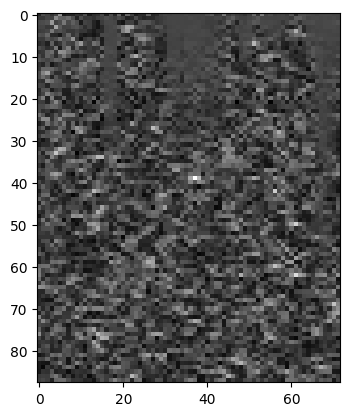

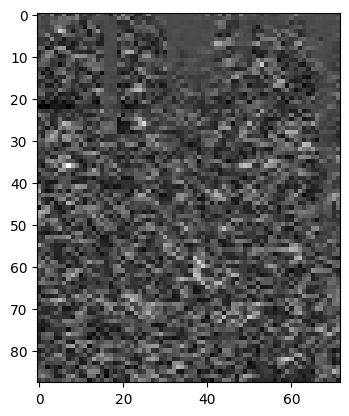

Predicted ccsn and was ccsn


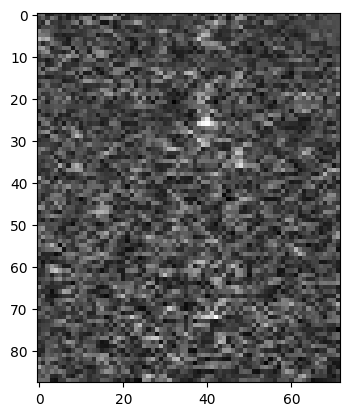

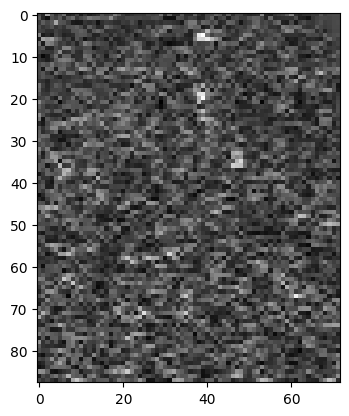

Predicted background and was background


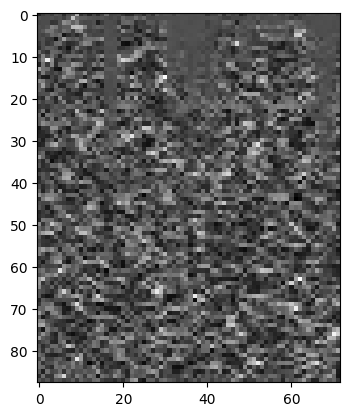

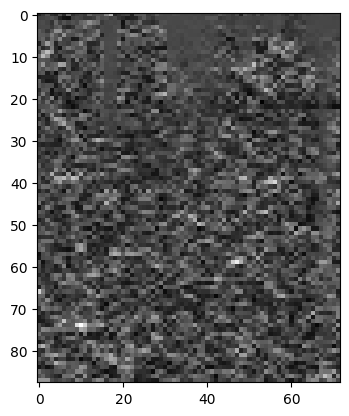

Predicted glitch and was glitch


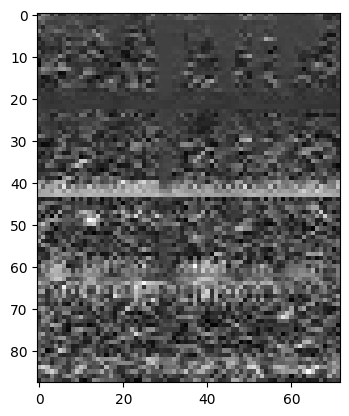

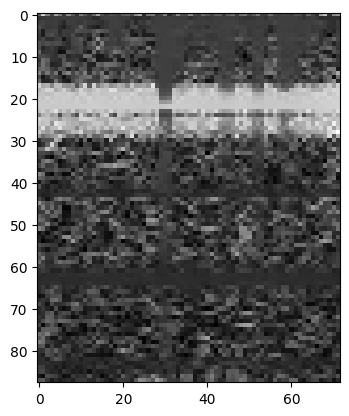

Predicted bbh and was bbh


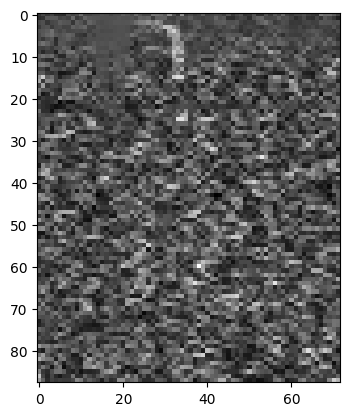

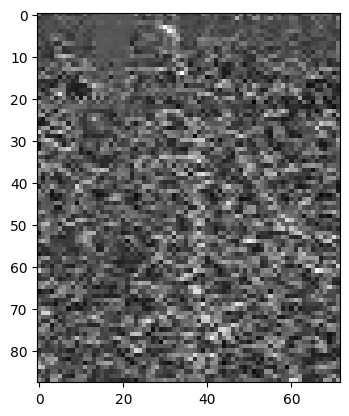

Predicted glitch and was glitch


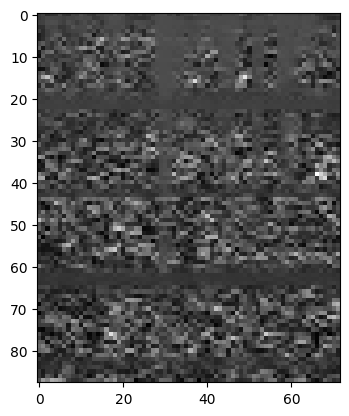

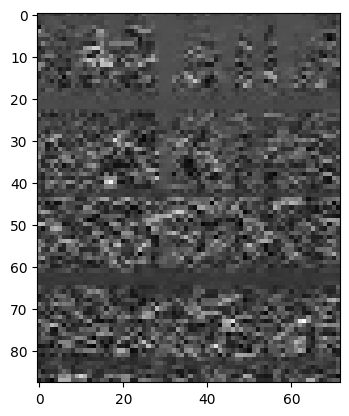

Predicted ccsn and was ccsn


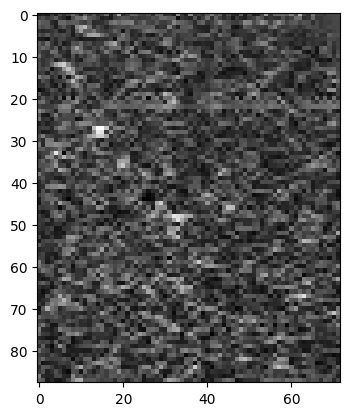

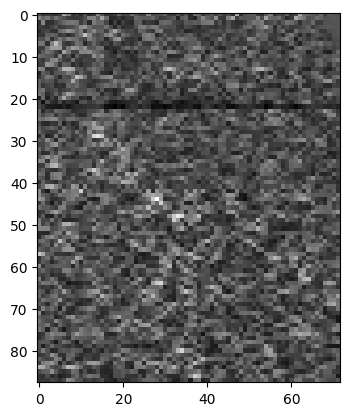

Predicted ccsn and was ccsn


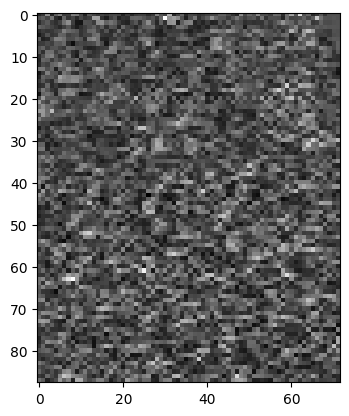

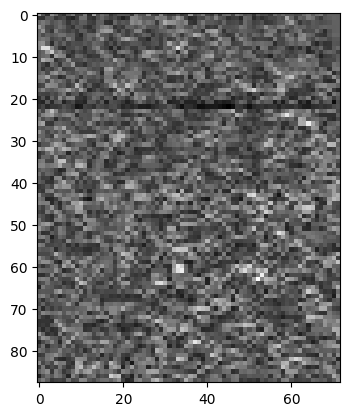

Predicted glitch and was glitch


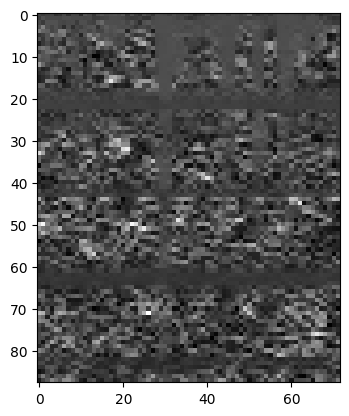

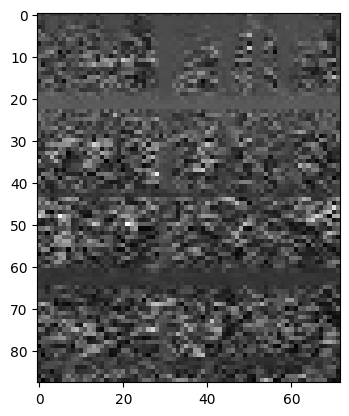

Predicted glitch and was glitch


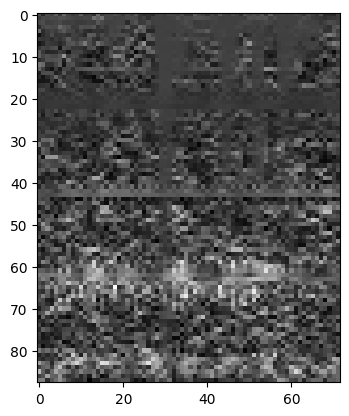

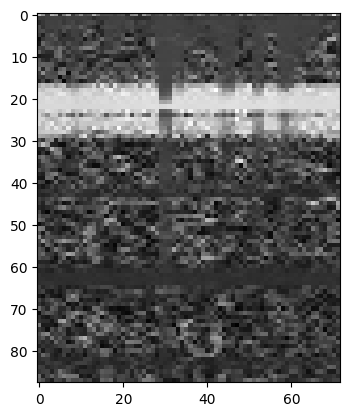

Predicted glitch and was glitch


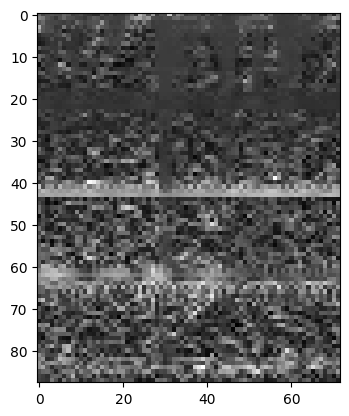

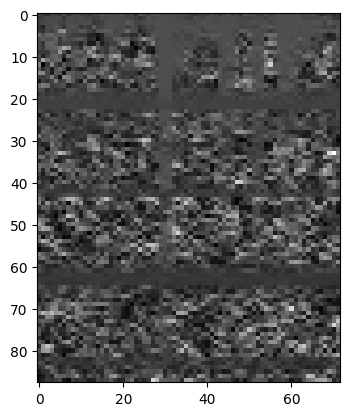

Predicted glitch and was glitch


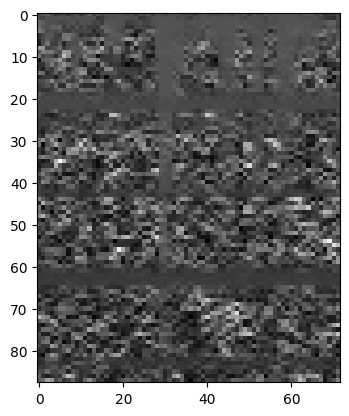

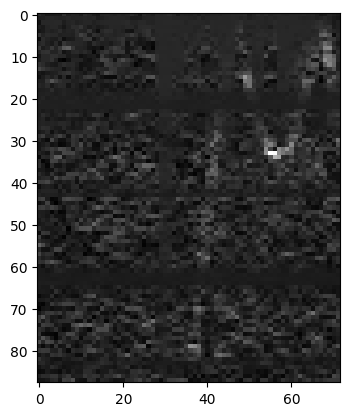

Predicted background and was background


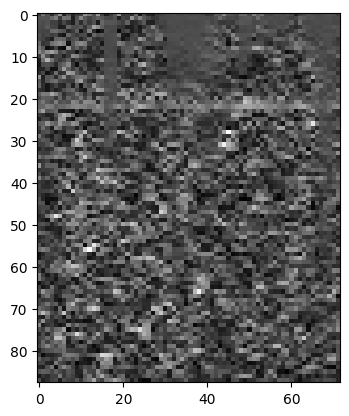

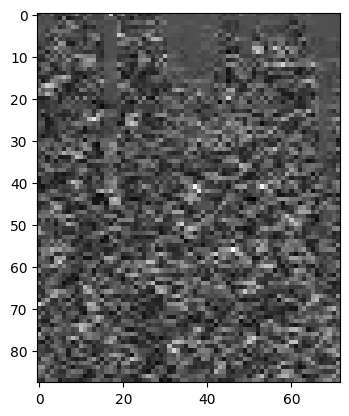

Predicted ccsn and was ccsn


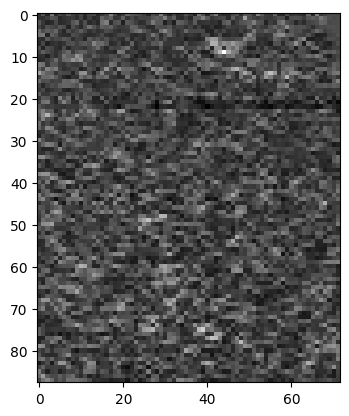

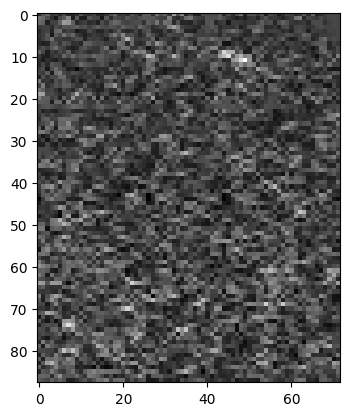

Predicted background and was background


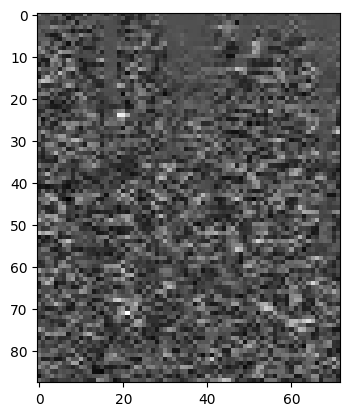

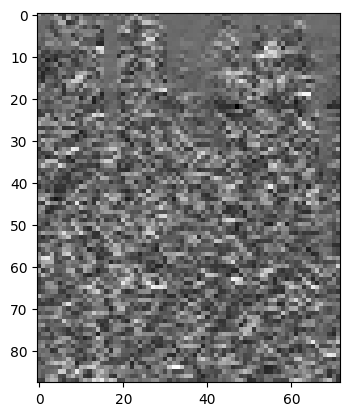

Predicted glitch and was glitch


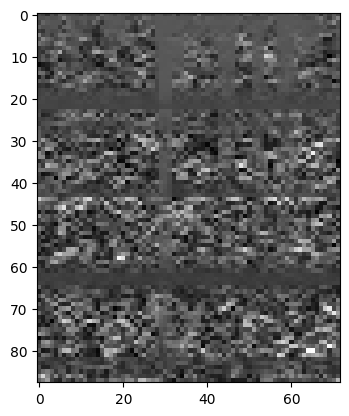

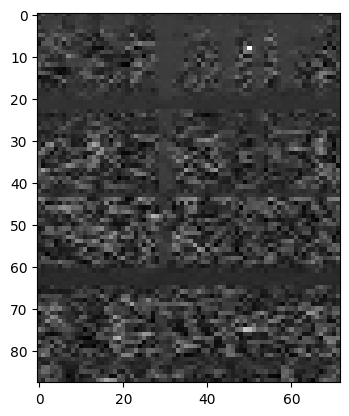

Predicted glitch and was glitch


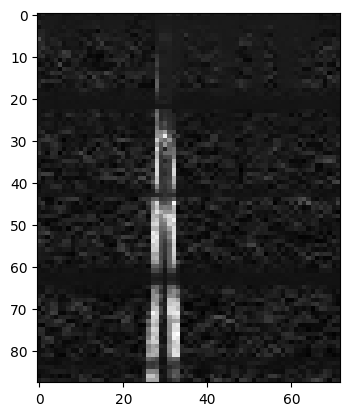

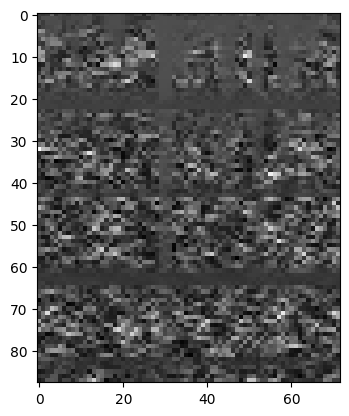

Predicted ccsn and was ccsn


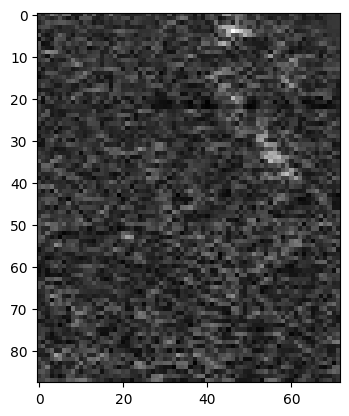

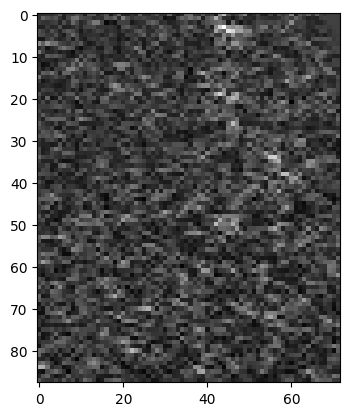

Predicted background and was background


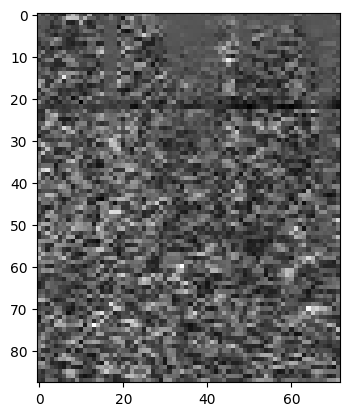

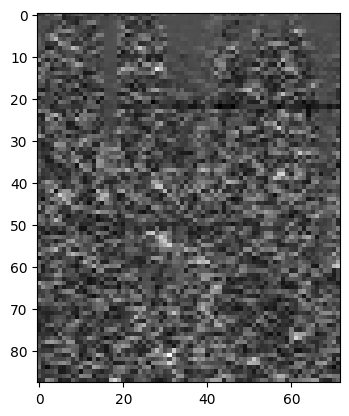

Predicted ccsn and was ccsn


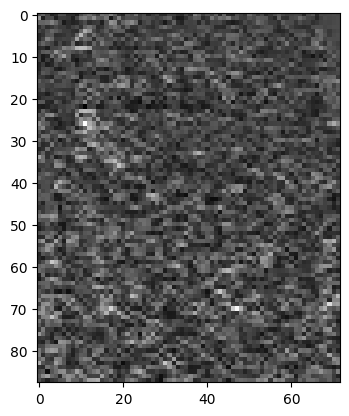

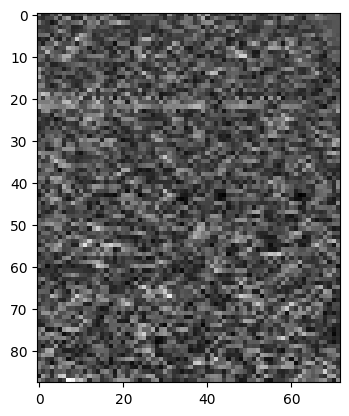

Predicted background and was background


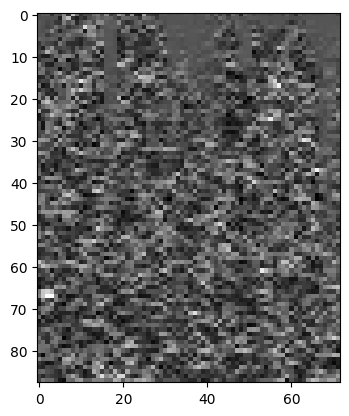

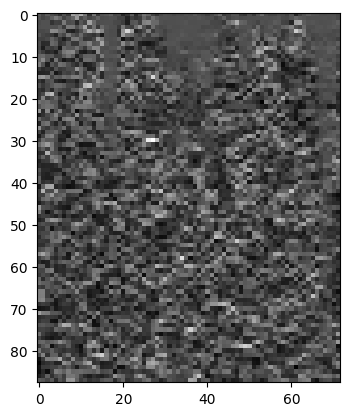

Predicted glitch and was glitch


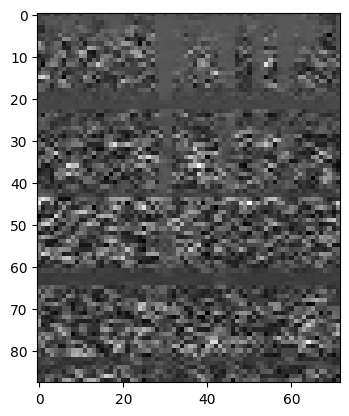

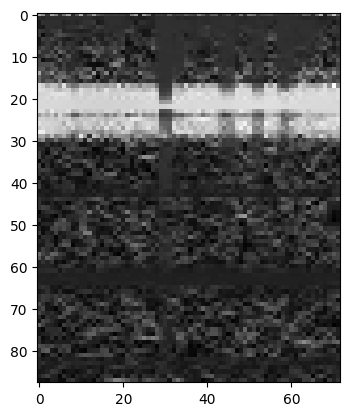

Predicted glitch and was glitch


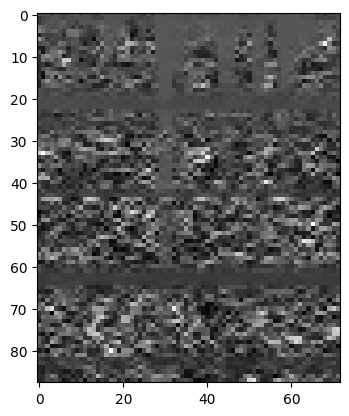

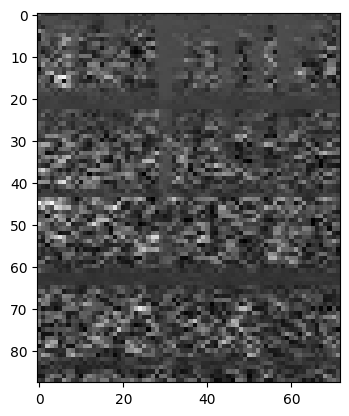

Predicted ccsn and was ccsn


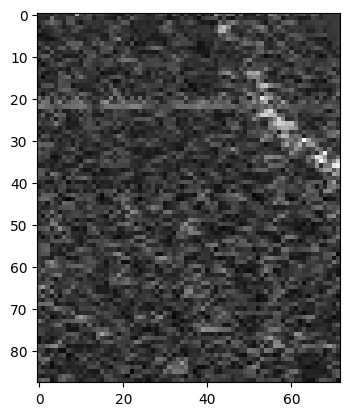

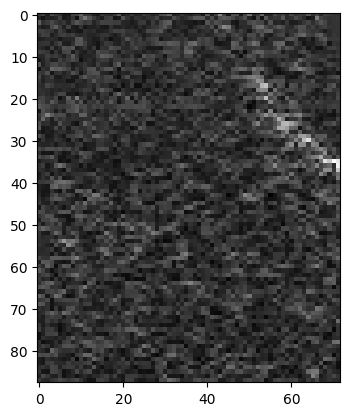

Predicted glitch and was glitch


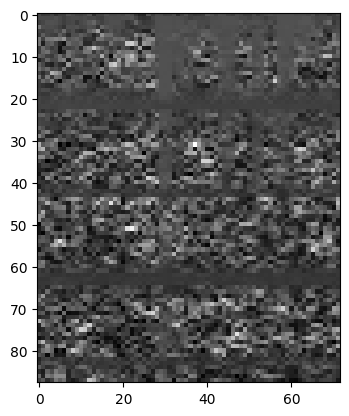

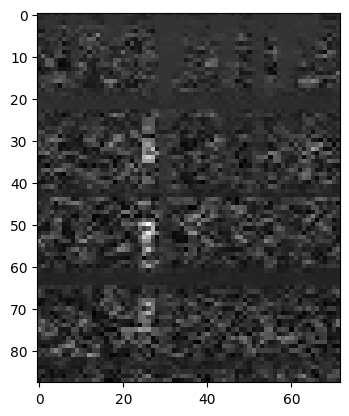

Predicted background and was background


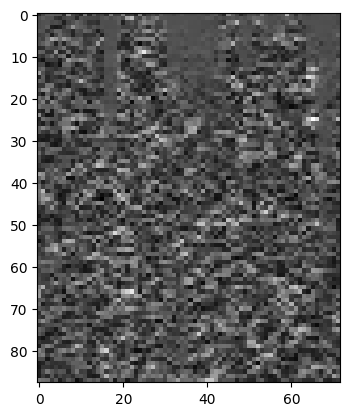

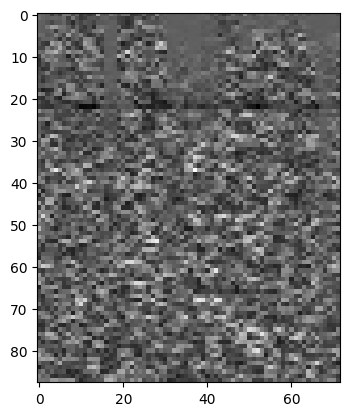

Predicted glitch and was glitch


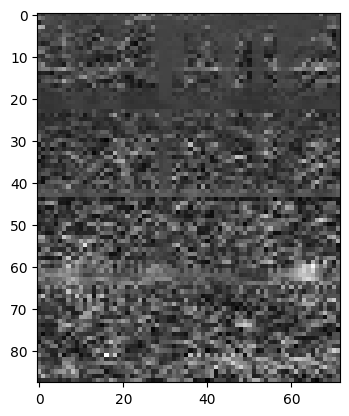

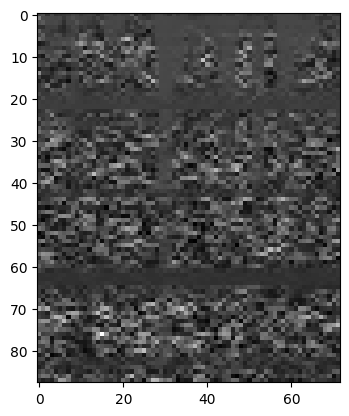

Predicted glitch and was glitch


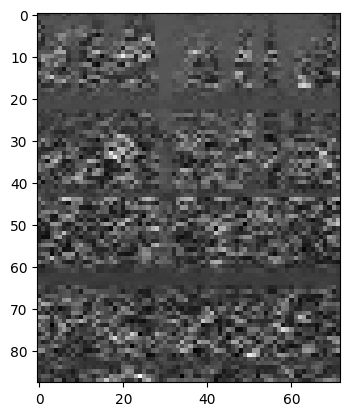

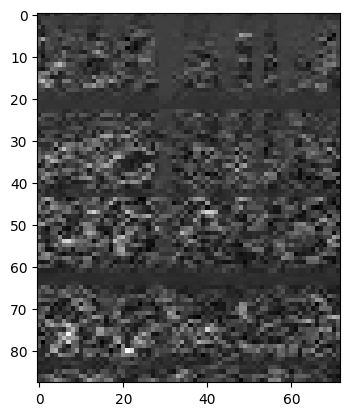

Predicted bbh and was bbh


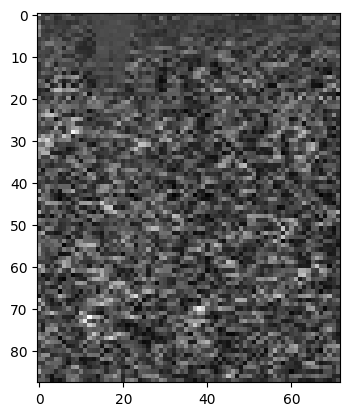

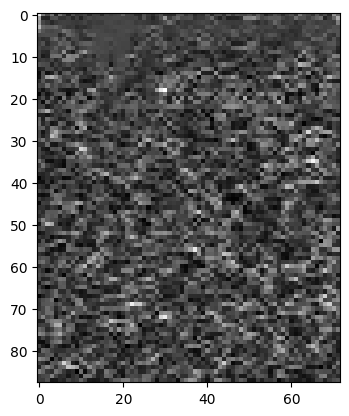

Predicted background and was background


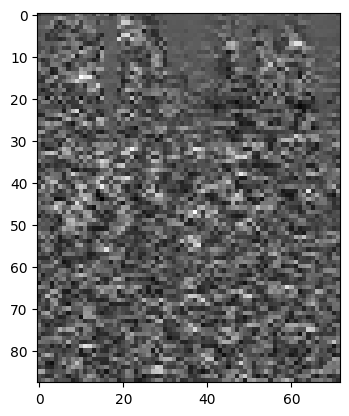

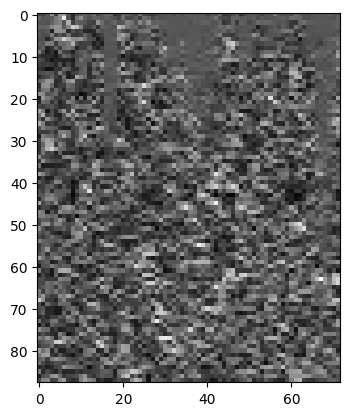

Predicted ccsn and was ccsn


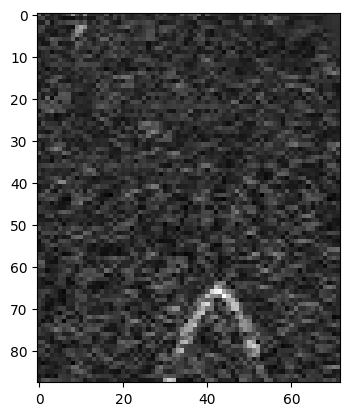

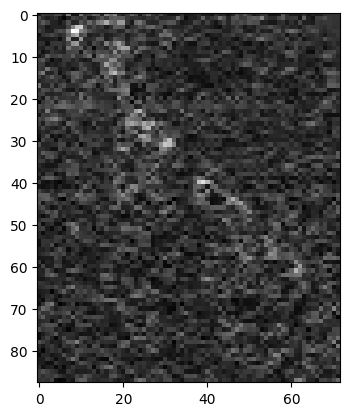

Predicted glitch and was glitch


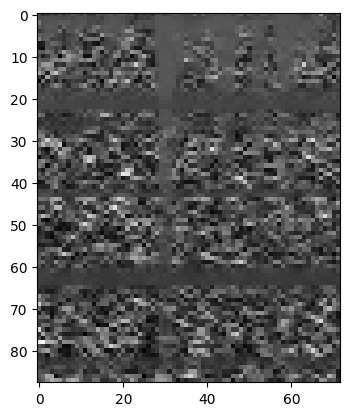

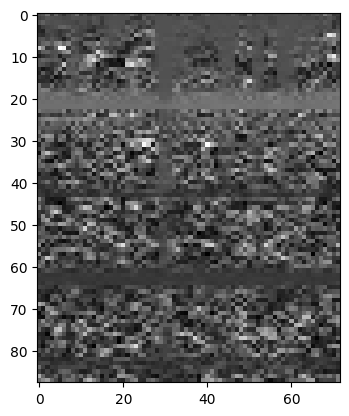

Predicted background and was background


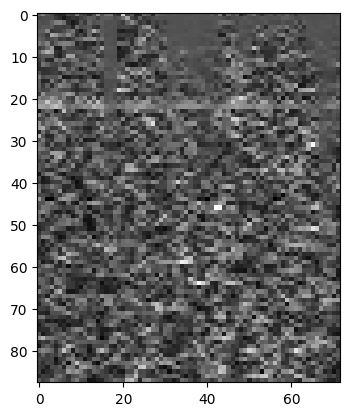

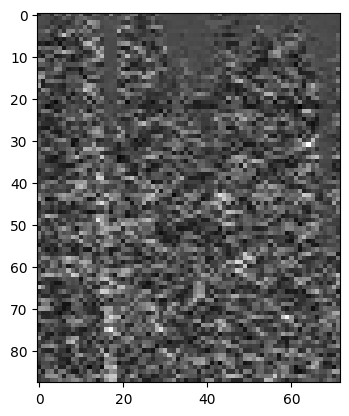

Predicted glitch and was glitch


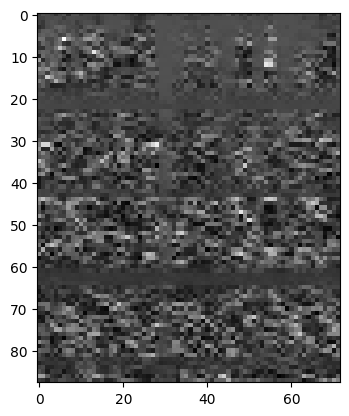

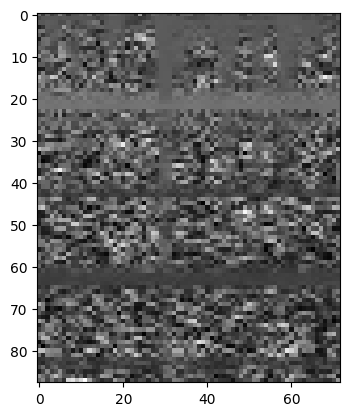

Predicted background and was background


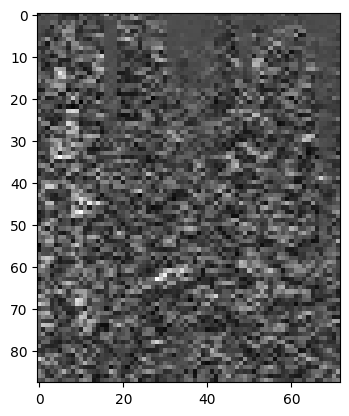

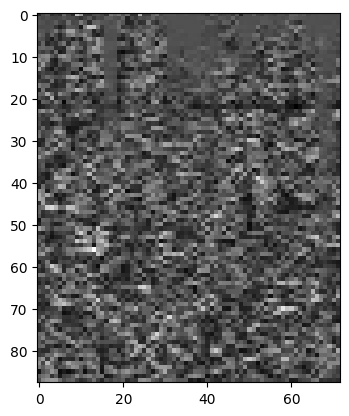

Predicted bbh and was bbh


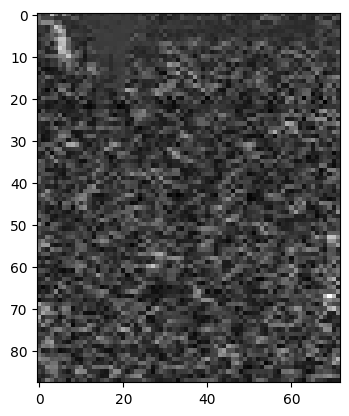

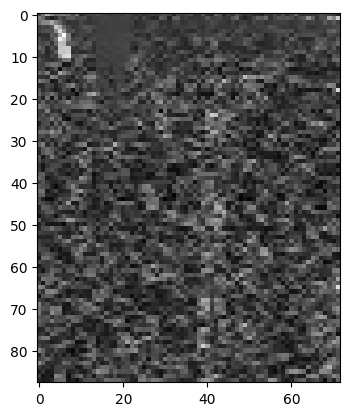

Predicted glitch and was glitch


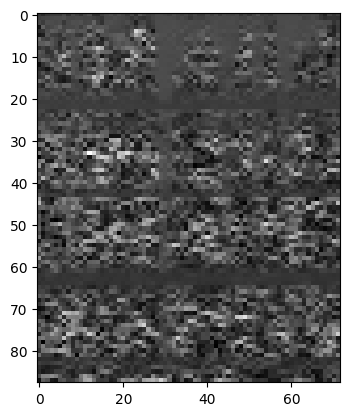

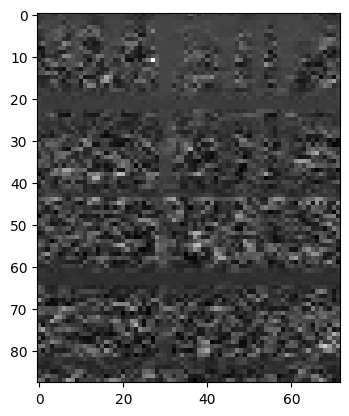

Predicted ccsn and was ccsn


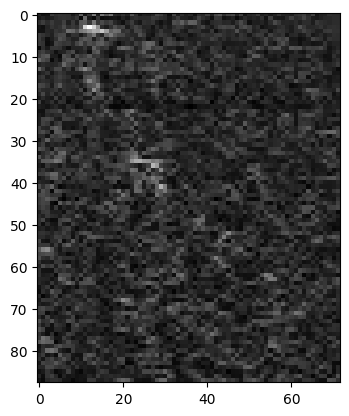

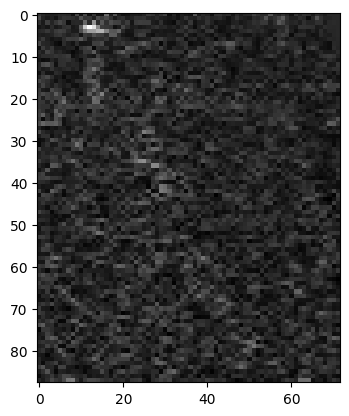

Predicted glitch and was glitch


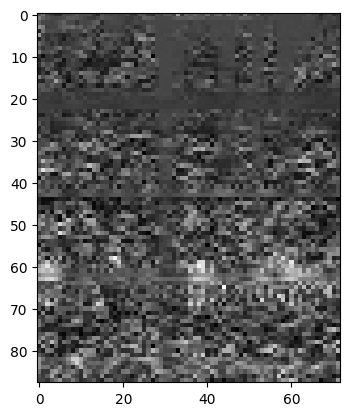

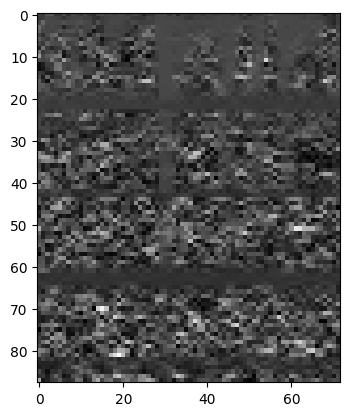

Predicted glitch and was glitch


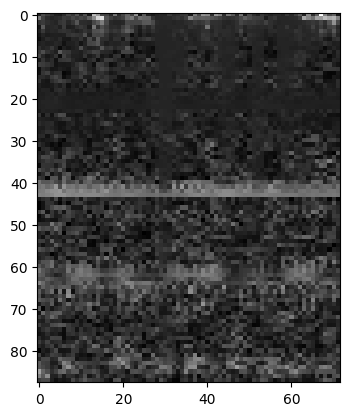

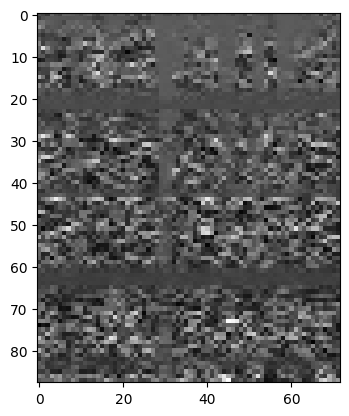

Predicted bbh and was bbh


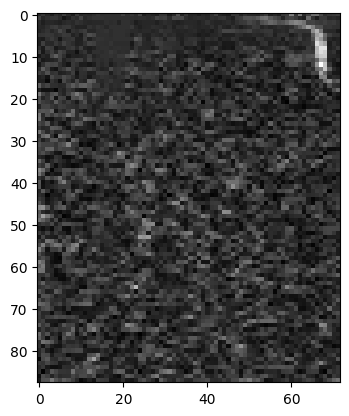

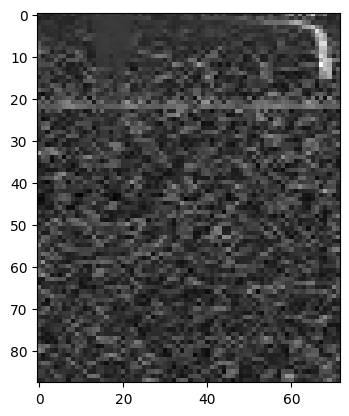

Predicted bbh and was bbh


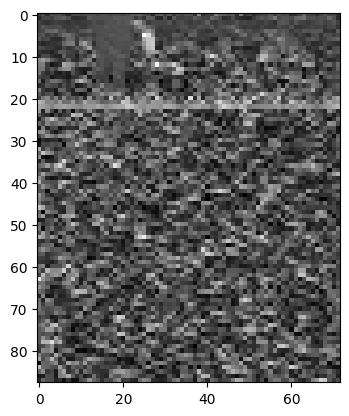

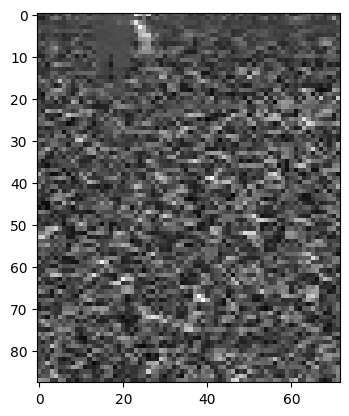

Predicted ccsn and was ccsn


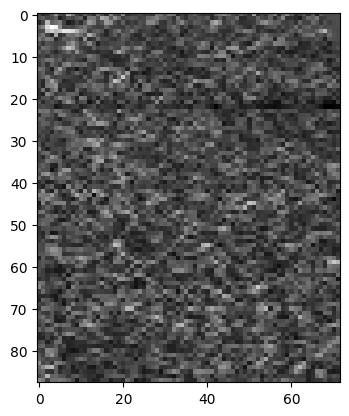

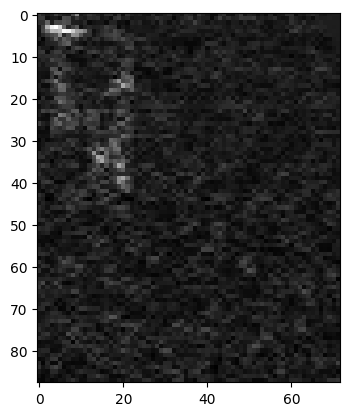

Predicted background and was background


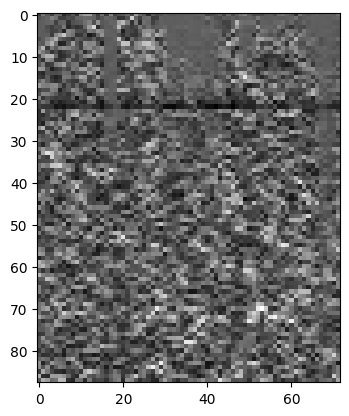

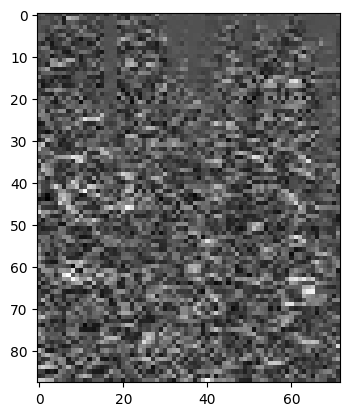

Predicted glitch and was glitch


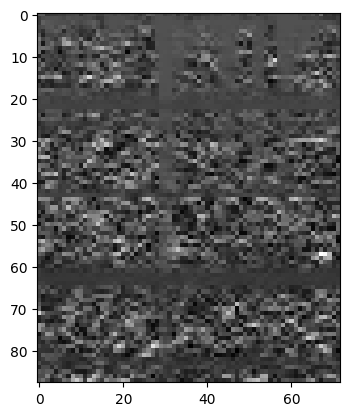

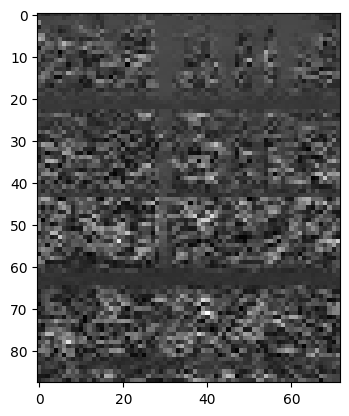

Predicted ccsn and was ccsn


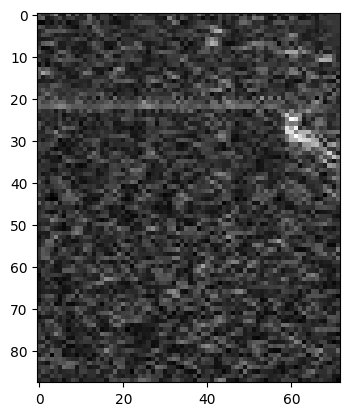

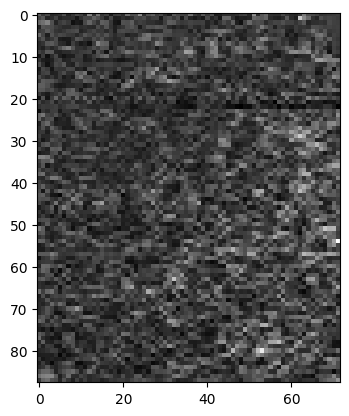

Predicted bbh and was bbh


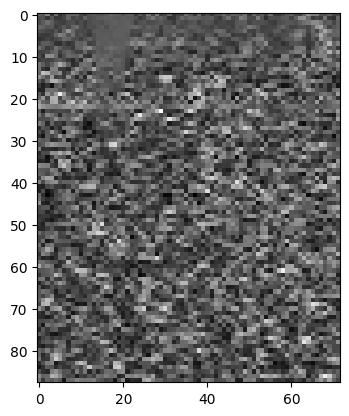

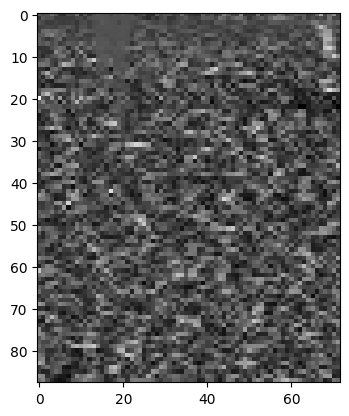

Predicted ccsn and was ccsn


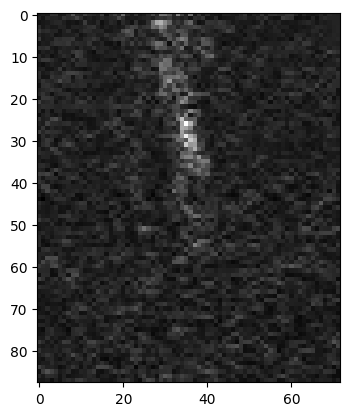

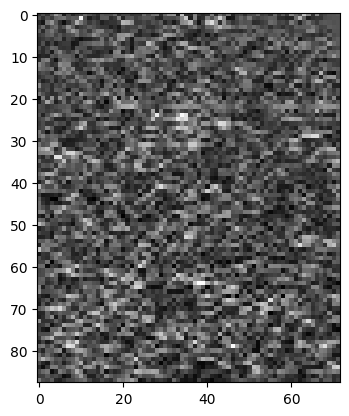

Predicted bbh and was bbh


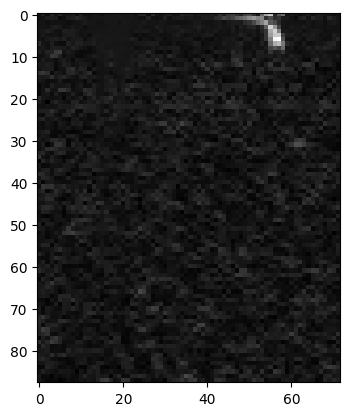

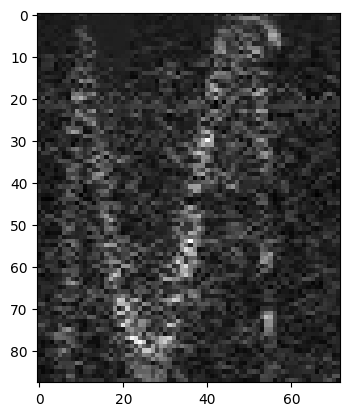

Predicted glitch and was glitch


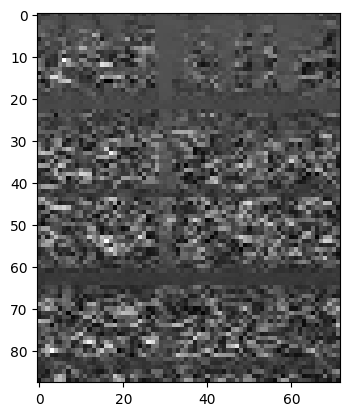

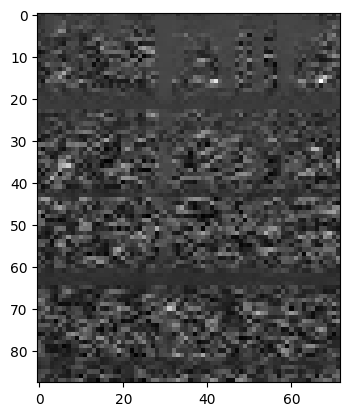

Predicted glitch and was glitch


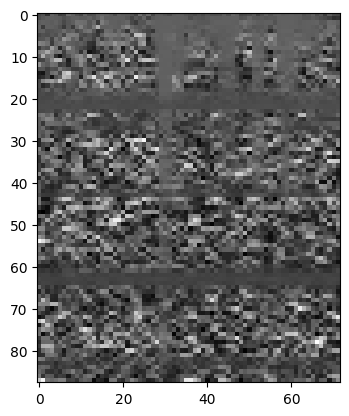

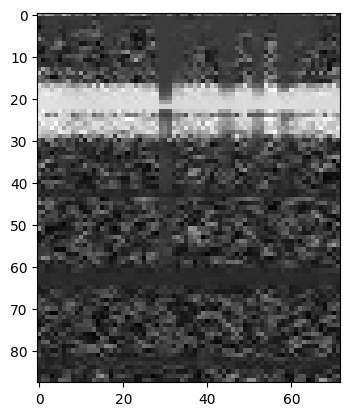

Predicted bbh and was bbh


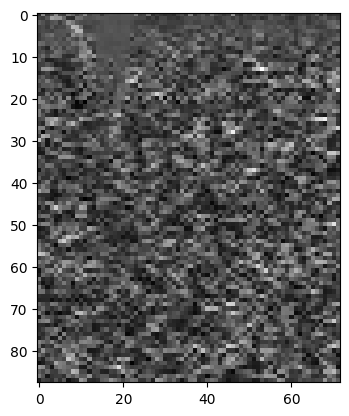

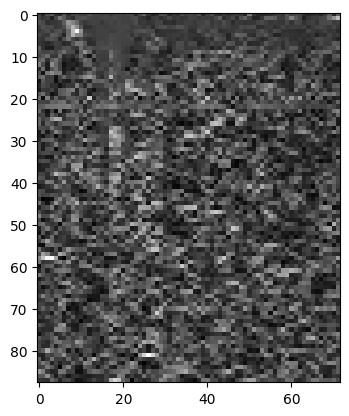

Predicted bbh and was bbh


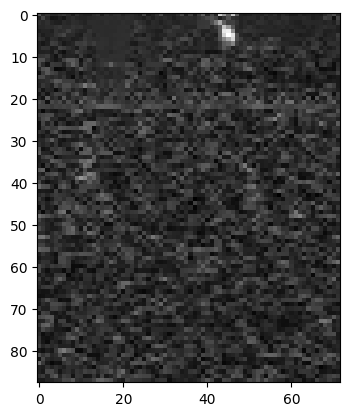

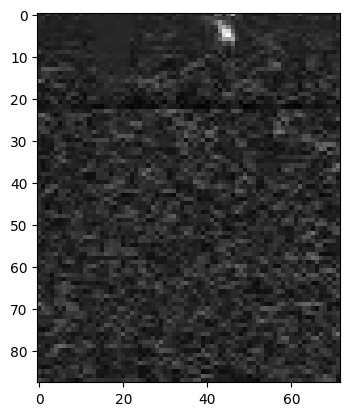

Predicted glitch and was glitch


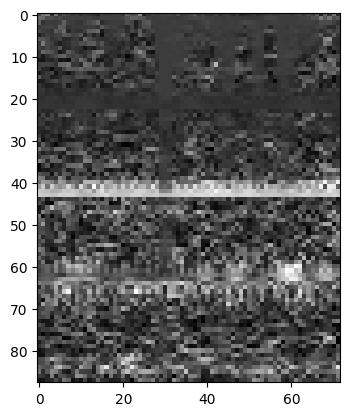

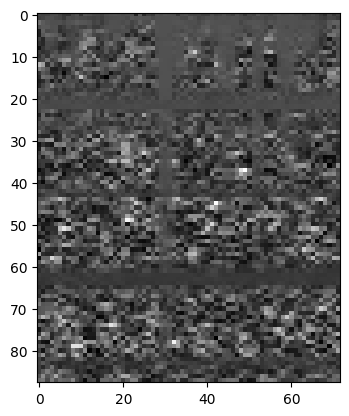

Predicted ccsn and was ccsn


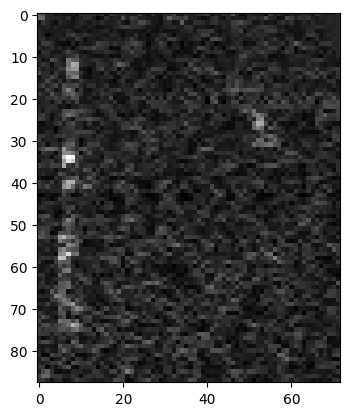

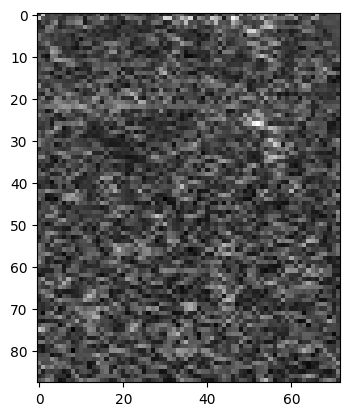

Predicted background and was background


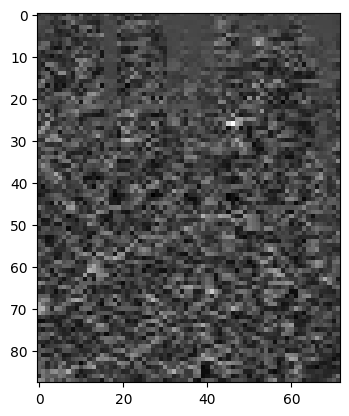

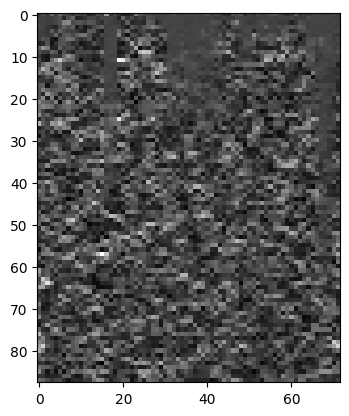

Predicted glitch and was glitch


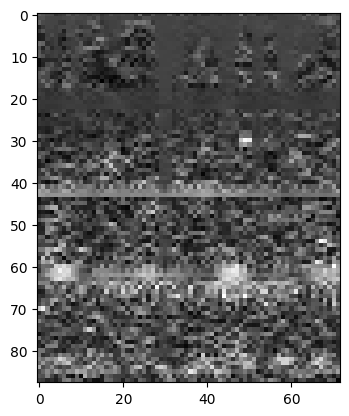

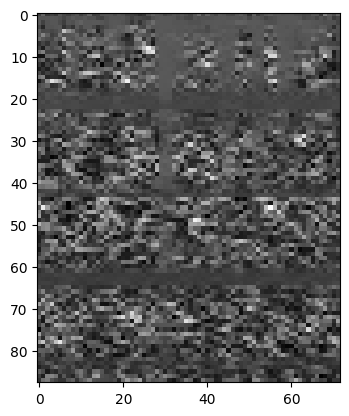

Predicted glitch and was glitch


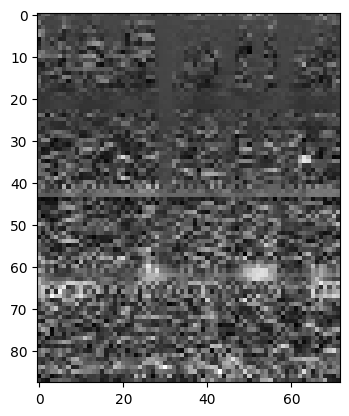

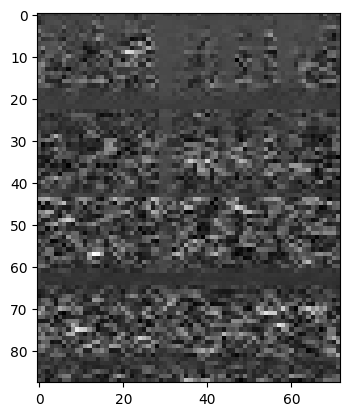

Predicted background and was background


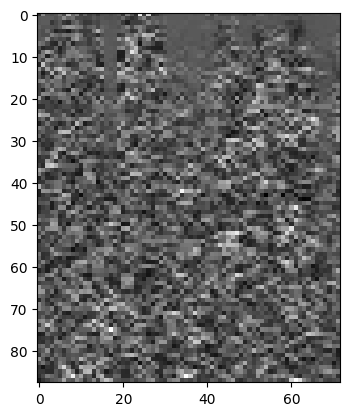

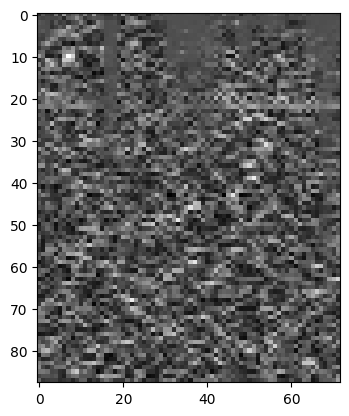

Predicted glitch and was glitch


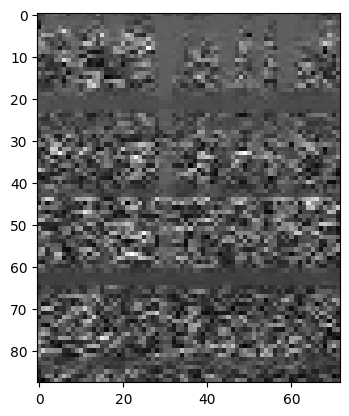

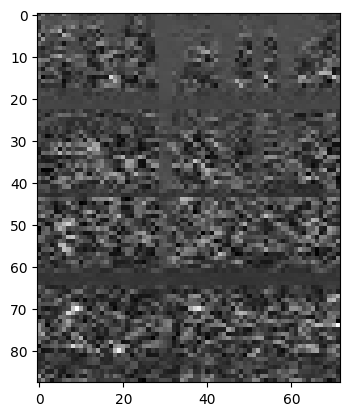

Predicted ccsn and was ccsn


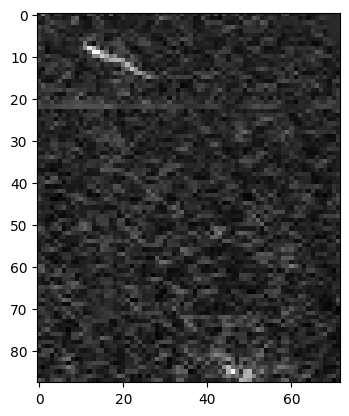

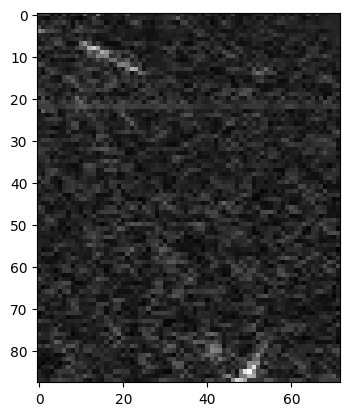

Predicted bbh and was bbh


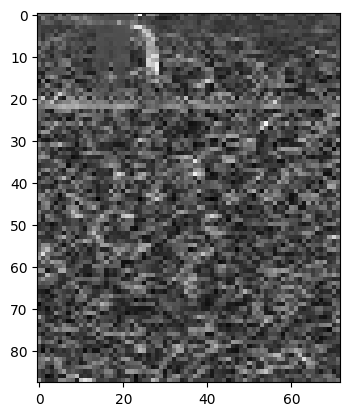

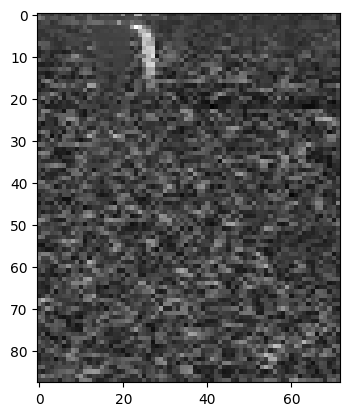

Predicted glitch and was glitch


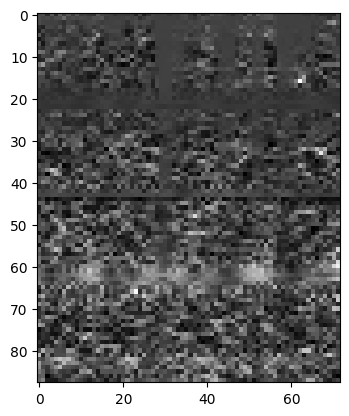

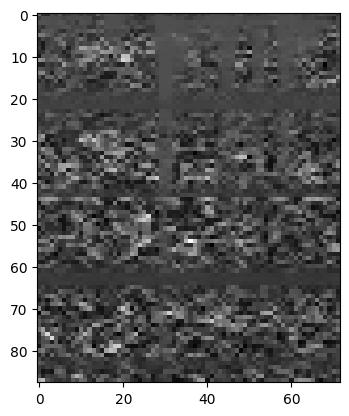

Predicted glitch and was glitch


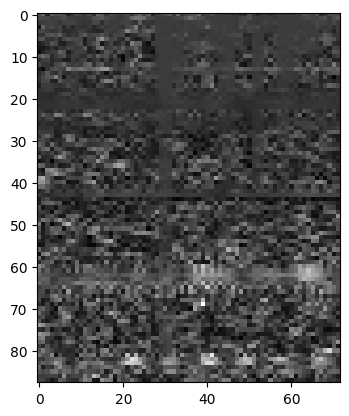

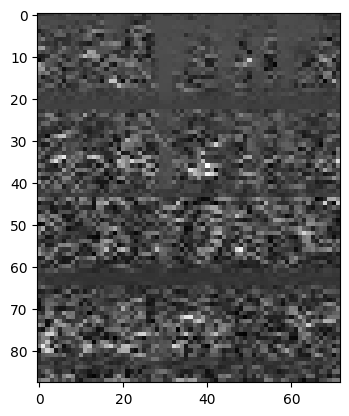

Predicted background and was background


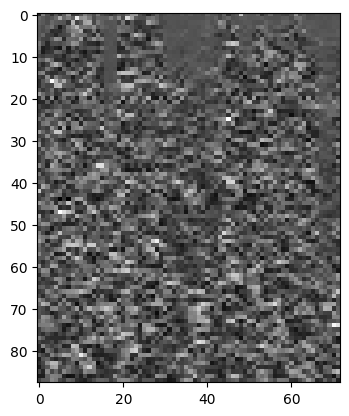

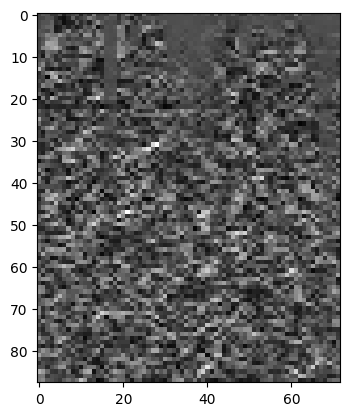

Predicted glitch and was glitch


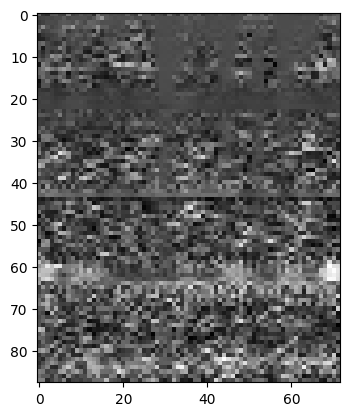

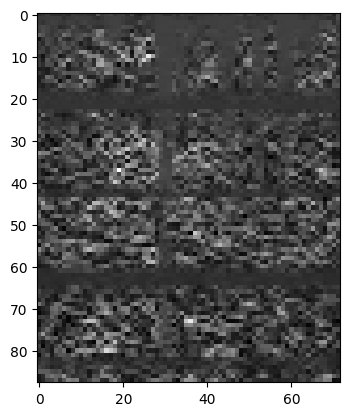

Predicted background and was background


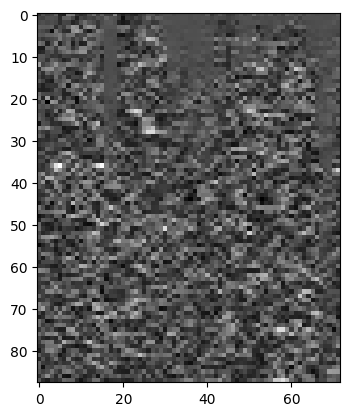

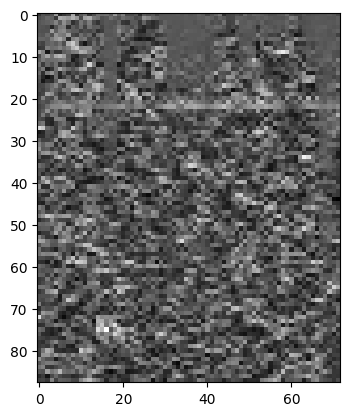

Predicted background and was background


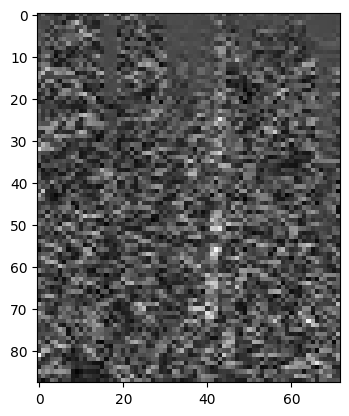

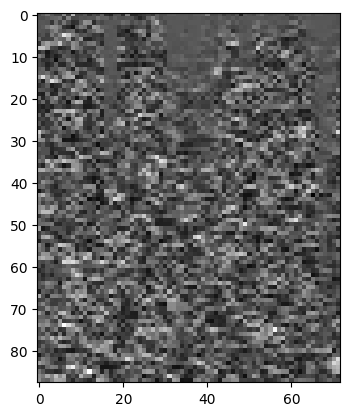

Predicted background and was background


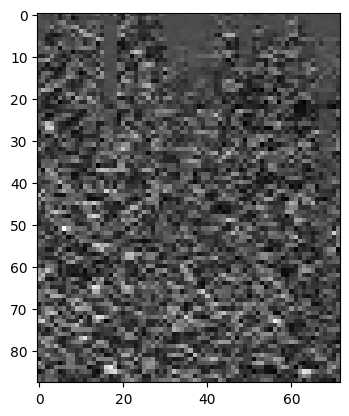

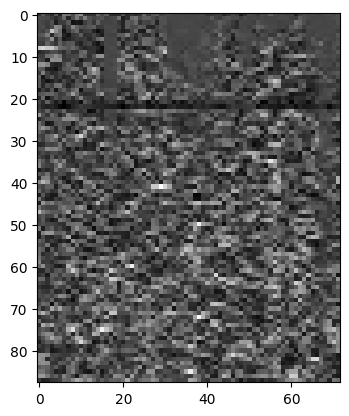

Predicted ccsn and was ccsn


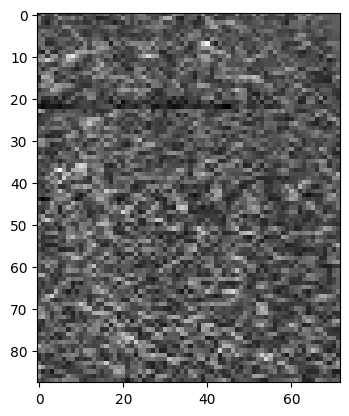

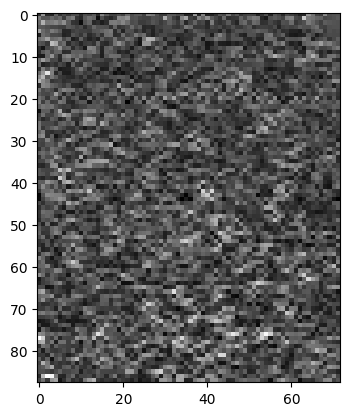

Predicted glitch and was glitch


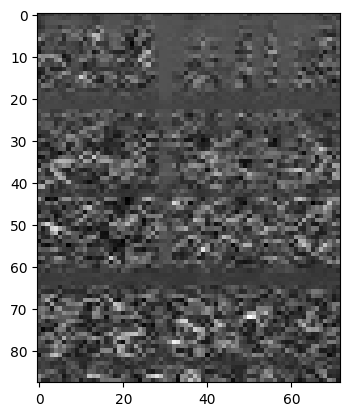

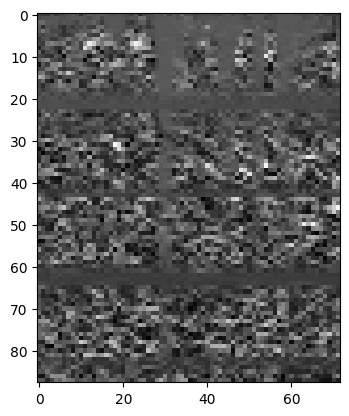

Predicted glitch and was glitch


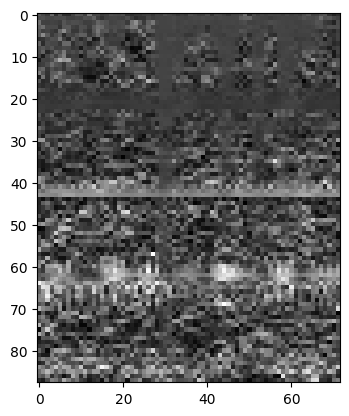

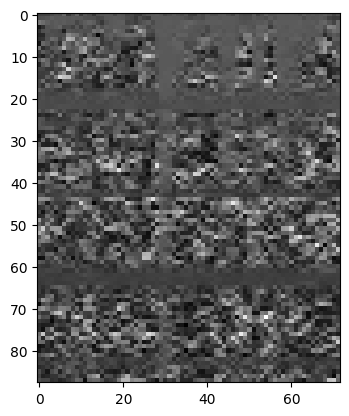

Predicted background and was background


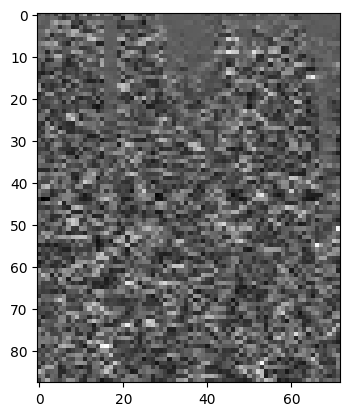

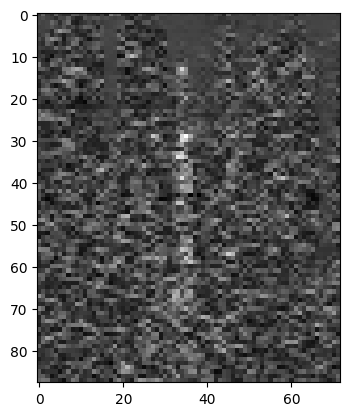

Predicted glitch and was glitch


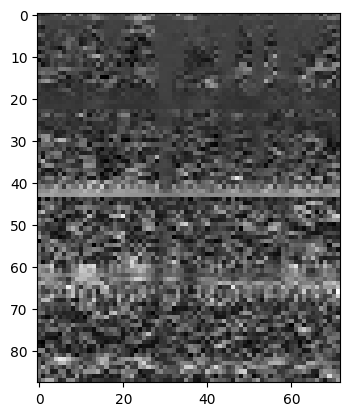

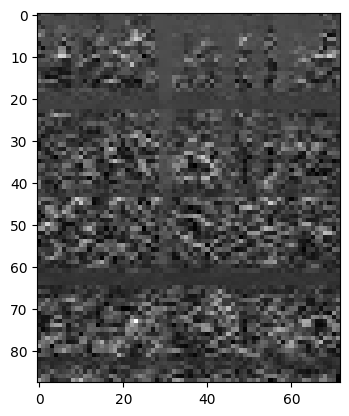

Predicted background and was background


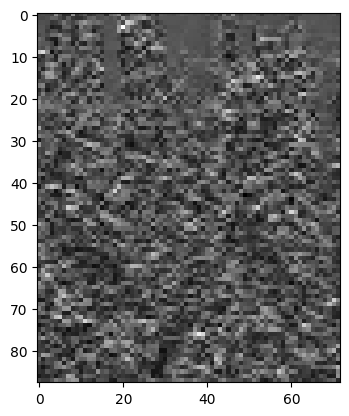

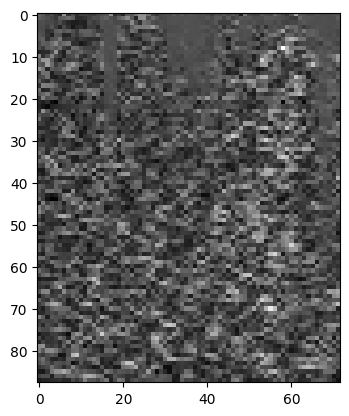

Predicted bbh and was bbh


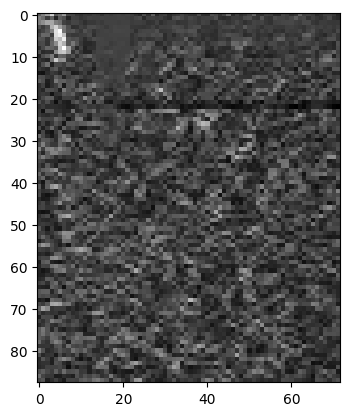

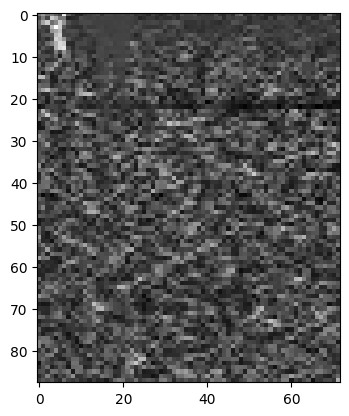

Predicted bbh and was bbh


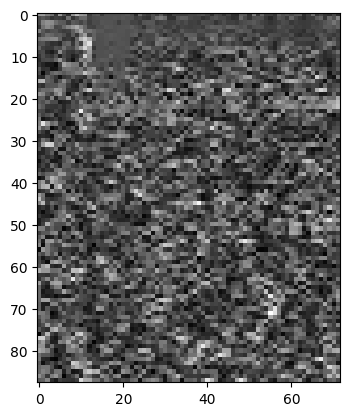

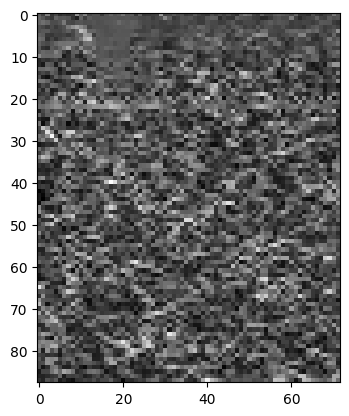

Predicted bbh and was bbh


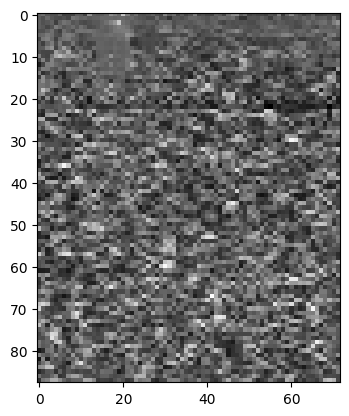

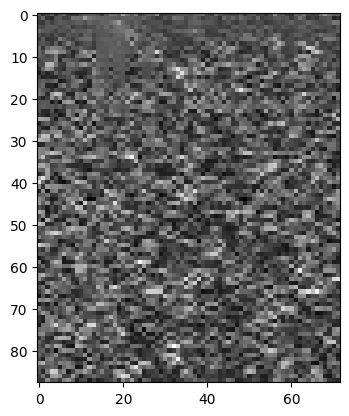

Predicted ccsn and was ccsn


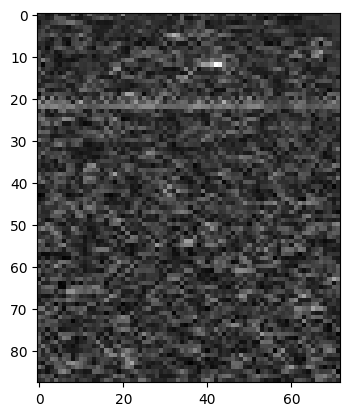

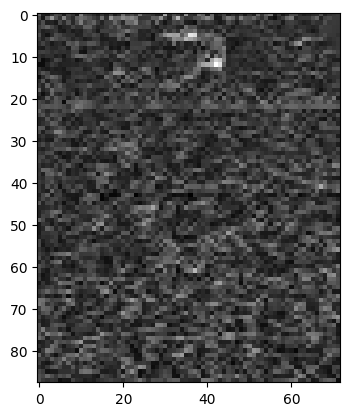

Predicted bbh and was bbh


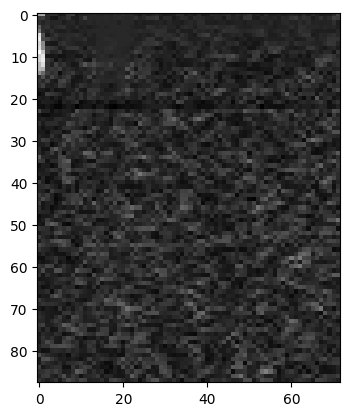

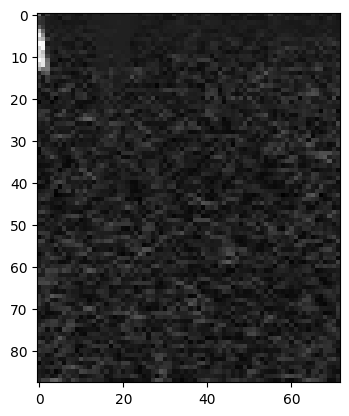

Predicted background and was background


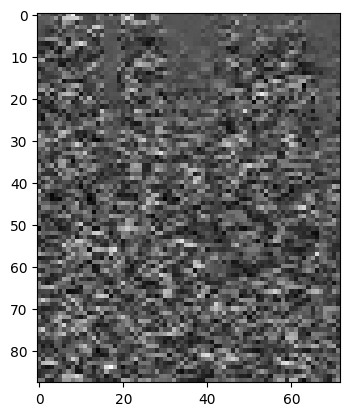

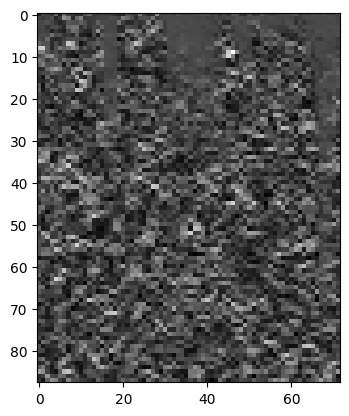

Predicted glitch and was glitch


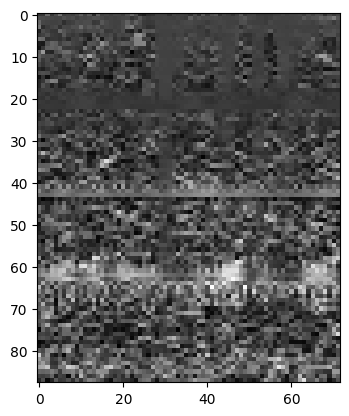

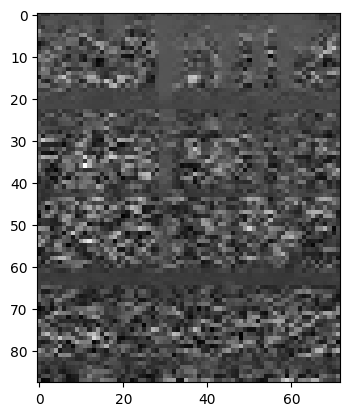

Predicted glitch and was glitch


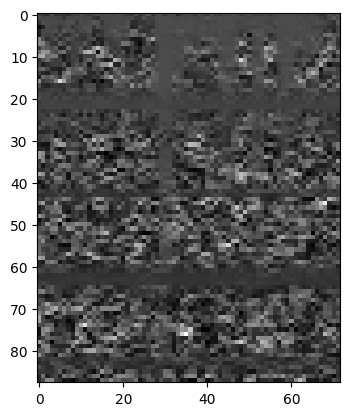

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [118]:
### Print correct predictions

def show_correct(loader, model):
    
        model.eval()
        print('Showing correct predictions\n')
        
        with torch.no_grad():
            for images, labels in loader:
                scores = model(images.float())
                _, predictions = scores.max(1)
                correct = (predictions == labels).nonzero()
                for i in correct:
                    pred = (predictions.numpy())[i]
                    label = (labels.numpy())[i]
                    print(f'Predicted {label_dict[pred]} and was {label_dict[label]}')
                    plt.imshow(images[i,0,:,:][0], cmap='gray')
                    plt.show()
                    plt.imshow(images[i,1,:,:][0], cmap='gray')
                    plt.show()

show_correct(dataloader, model)